<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/bike_train_duration/veloopros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вводная часть

Это исследование взаимосвязи функциональной мощности и длительности тренировок велосипедистов и триатлетов. Анализ проведен по данным опроса спортсменов, который проведился в телеграмм-канале [Тренер Сурен](https://t.me/surencoach/1082). Всего в опросе приняло участие более 250 спортсменов. Требовалось обнаружить и описать взаимосвязи объема тренировок с мощностью, а также возможные связи с другими параметрами ттренировок и спорстменов.

Данные формы опроса проходят ручную предобработку. Явные аномалии, где это возможно, корректируются. Ответы с пустыми ключевыми для исследования колонками - удаляются. Данные для расчета экспортируются в неудобном для анализа формате, поэтому требуется предобработка данных.

Ход исследования:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Определение корреляции числовых показателей
- Определение взаимосвязи FTP и веломинут
- Когортный анализ данных по FTP, веломинутам и стажу
- Изучение волнового характера роста FTP с ростом веломинут?
- Сравнение тренировок велосипедистов и триатлетов
- Сравнение способов определения FTP


# Процедуры и функции

В этом разделе размещены используемые в анализе процедуры и функции

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import math
import numpy as np
import scipy.stats as stats
from matplotlib.colors import TwoSlopeNorm

In [238]:
pd.options.display.max_colwidth = 9000

In [239]:
#Цвет RGB в HEX
def rgba2hex(rgba):
    r = int(rgba[0] * 255)
    g = int(rgba[1] * 255)
    b = int(rgba[2] * 255)
    return f'#{r:02x}{g:02x}{b:02x}'


In [240]:
#Список градиентов цвета в зависимости от входной величины
def gradient_by_value(col = pd.Series([]), gradient = plt.cm.RdYlGn_r):
    norm = TwoSlopeNorm(vmin=col.min(), vcenter=col.mean(), vmax=col.max())
    colors = [rgba2hex(gradient(norm(c))) for c in col]
    return colors

In [241]:
# Вывод проверки выброк для тестирования
def chek_dd_test(d_test1, d_test2):
  norm1 = False
  norm2 = False
  pval = stats.normaltest(d_test1)[1]
  if pval < 0.05:
     print(f'Первая выборка размером {len(d_test1)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Первая выборка размером {len(d_test1)} прошла проверку на нормальное распределение. pval = {pval}')
      norm1 = True

  pval = stats.normaltest(d_test2)[1]
  if pval < 0.05:
      print(f'Вторая выборка размером {len(d_test2)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Вторая выборка размером {len(d_test2)} прошла проверку на нормальное распределение. pval = {pval}')
      norm2 = True

  equal_var = False
  pval = stats.levene(d_test1, d_test2)[1]
  if pval < 0.05:
      print(f'Дисперсии выборок НЕ близки. pval = {pval}. Применяем equal_var=False')
  else:
      print(f'Дисперсии выборок близки. pval = {pval}. Применяем equal_var=True ')
      equal_var = True
  return norm1, norm2, equal_var

In [242]:
# Вывод результатов тестирования в зависимост от pvalue
def pval_print (pval, h0='', h1=''):
    print('В результате теста получено p-value', pval)
    if pval < 0.05:
        print('НЕ можем принять нулевую гипотезу, принимаем альтернативную:')
        print(' ------> \033[31m\033[1m', h1, '\033[0m')
    else:
        print('НЕ можем отвегнуть нулевую гипотезу, принимаем ее:')
        print(' ------> \033[32m\033[1m', h0, '\033[0m')

In [243]:
# Тестирование сравнения двух выборок
def test_selection (d_test1, d_test2, side='two-sided', h0='', h1=''):
  norm1, norm2, e_var = chek_dd_test(d_test1, d_test2)
  l1 = (len(d_test1) >= 30)
  l2 = (len(d_test2) >= 30)
  print()
  if (norm1 & norm2): print('Обе выборки имеют нормальное распределение!')
  if ((l1 or norm1) and (l2 or norm2)) :
    if (l1 & l2): print(f'Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest')
    print()
    print('--- Проводим TTest ---')
    pval = stats.ttest_ind(d_test1, d_test2, alternative = side, equal_var=e_var)[1]
    pval_print(pval, h0, h1)
    print()
    print('Для сравнения проведем и параметрический тест Манна-Уитни')
    print()
  else:
    print(f'Выборки маленькие ({len(d_test1)} / {len(d_test2)}) - НЕЛЬЗЯ применять ttest')

  print('---- Проводим Test Mann-Whitneyu ----')
  pval = stats.mannwhitneyu(d_test1, d_test2, alternative = side)[1]
  pval_print(pval, h0, h1)

In [244]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_stat(s, color='orange', p = 0.05):
    return ['background-color: '+color if val < p  else 'background-color: none' for val in s]

In [245]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_over(s, color='lime', p = 0.5):
    return ['background-color: '+color if val > p  else 'background-color: none' for val in s]

# Загрузка данных

Данные для аналза хранятся в excel файле на google.disc

In [246]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dtp/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/bike_duration/

/content/drive/My Drive/Colab Notebooks/bike_duration


In [247]:
data = pd.read_excel('bike_train_duration.xlsx')

In [248]:
data.head()

,Timestamp,Ваш вес,Ваш пол,Ваш вид спорта,"Какой у вас средний тренировочный объем велотренировок в неделю в часах за последний год (укажите, пожалуйста, в формате чч:мм:сс)","Если знаете, то укажите какой у вас средний тренировочный объем в неделю в часах за последний год по другим активности вместе взятым (силовые, бег, плавание и тд, в формате чч:мм:сс)",Сколько месяцев или лет (уточните в ответе) у вас общий тренировочный стаж в тренировках по велосипеду? Если был значительный перерыв в тренировках также напишите про это.,"Какой у вас наивысший уровень анаэробного порога (часовой мощности или ФТП) в этом сезоне? Укажите цифру по мощности (например, 210)",Каким способом вы определили ваш пиковый анаэробный порог (ФТП) в сезоне?,Стаж ручное редактировние
0,2024-12-26 12:58:01.835,73.0,Мужской,Триатлон,6:00:00,11:00:00,4 года,285,По результатом полевых тестирований,48
1,2024-12-26 12:59:07.121,73.0,Мужской,Велоспорт,13:16:25,NaN,4,320,Расчетным путем исходя их результатов гонок,48
2,2024-12-26 13:00:24.132,73.0,Мужской,Триатлон,05:43:57,10:49:50,5 лет,215,Из результатов лабораторного тестирования,60
3,2024-12-26 13:00:38.202,82.0,Мужской,Триатлон,4:30:00,8:30:00,2года,215,Seift,24
4,2024-12-26 13:01:04.913,77.0,Мужской,Трейл,00:44:29,NaN,"Где то с прошлого лета крутил когда купил вело тренажер , кручу переиодически не постоянно",257,По результатом полевых тестирований,18


Переименовываем колонки

In [249]:
data.columns = ('date_answer' , 'weigth', 'gender', 'sport', 'bike_hours', 'train_hours', 'train_stag', 'ftp', 'ftp_source', 'stag_r')

In [250]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_answer  283 non-null    datetime64[ns]
 1   weigth       283 non-null    float64       
 2   gender       283 non-null    object        
 3   sport        283 non-null    object        
 4   bike_hours   283 non-null    object        
 5   train_hours  206 non-null    object        
 6   train_stag   283 non-null    object        
 7   ftp          283 non-null    int64         
 8   ftp_source   283 non-null    object        
 9   stag_r       283 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 22.2+ KB


In [251]:
data_l0 = len(data)

# Предобработка данных

Преобразуем исходные данные к удобоваримому виду

In [252]:
for i in range(0, len(data)):
# ------------- велотренировки ---------------------------
    bh = str(data.loc[i, 'bike_hours'])
    if bh != bh: bh = '0'
    bh = bh.replace(',', '.')
    bh = bh.replace('-', ':')
    bh = re.sub(r'[^0-9.:]+', '', bh)
    digits = []
    digits.append(re.split(':', bh))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'bike_minute'] = minuts

# -------------- остальные тренировки -----------------------------
    th = str(data.loc[i, 'train_hours'])
    if th != th: th = '0'
    th = th.replace(',', '.')
    th = th.replace('-', ':')
    th = re.sub(r'[^0-9.:]+', '', th)
    digits = []
    digits.append(re.split(':', th))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'train_minute'] = minuts

# ------------ Стаж. Каша в данных ---------------------
#    st = str(data.loc[i, 'train_stag'])
#    if st != st: st = '0'
#
#    st = re.sub(r'[^0-9.:]+', '', st)
#    try:
#        stag = float(st)
#    except:
#        stag = 0
#    data.loc[i, 'stag_c'] = stag
#
# ------------ вес ----------------------------------
    wg = str(data.loc[i, 'weigth'])
    if wg != wg: wg = '0'
    wg = wg.replace(',', '.')
    wg = re.sub(r'[^0-9.:]+', '', wg)
    try:
        weigth = float(wg)
    except:
        weigth = 0
    data.loc[i, 'weigth_c'] = weigth


# ----------- FTP  ---------------------------------
    ftp = str(data.loc[i, 'ftp'])
    if ftp != ftp: ftp = '0'

    ftp = re.sub(r'[^0-9.:]+', '', ftp)
    try:
        ftpf = float(ftp)
    except:
        ftpf = 0
    data.loc[i, 'ftp_c'] = ftpf


Проверяем аномалии по колонкам

**Все выявленные тут аномалии правятся вручную в файле данных на гугл диске !!!!**

аномальный вес

In [253]:
data.query('weigth_c < 50 | weigth_c > 150')

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,stag_r,bike_minute,train_minute,weigth_c,ftp_c


аномальный FTP

In [254]:
data.query('ftp_c < 100 | ftp_c > 500')[['date_answer', 'gender', 'sport', 'ftp', 'ftp_c']]

,date_answer,gender,sport,ftp,ftp_c


аномальные веломинуты

*Здесь и далее, если речь идет о только о велотренировках, то используется термин "веломинуты"*


In [255]:
data.query('bike_minute < 30 | bike_minute > 1000')[['date_answer', 'gender', 'sport', 'bike_hours', 'bike_minute', 'ftp_c']]

,date_answer,gender,sport,bike_hours,bike_minute,ftp_c
154,2024-12-28 08:52:36.671,Мужской,Велоспорт,19:54:06,1194.0,323.0
187,2024-12-29 08:58:49.609,Мужской,"Бег, лыжи",00:25:29,25.0,260.0
232,2024-12-29 11:37:34.693,Мужской,Триатлон,17:45:00,1065.0,360.0


Аномальная длительность других тренировок

In [256]:
data.query('(train_minute > 0 & train_minute < 30) | train_minute > 1000')[['date_answer', 'gender', 'sport', 'train_hours', 'train_minute']]

,date_answer,gender,sport,train_hours,train_minute
123,2024-12-26 22:08:12.788,Мужской,Велоспорт,00:13:30,13.0
138,2024-12-27 09:14:37.500,Мужской,Велоспорт,00:15:00,15.0


Переназначаем индексы после предоботки

In [257]:
data = data.reset_index(drop = True)

In [258]:
print(f'После предобработки осталось данные по {len(data)} спортсменам. Изначально было {data_l0}')

После предобработки осталось данные по 283 спортсменам. Изначально было 283


In [259]:
#Расчет FTP в ватт/кг
data['ftp_weigth'] = data['ftp_c'] / data['weigth_c']

**Промежуточные итоги**

Предобработка исходных данных включала:
Очистку числовых данных от буквенных символов и перевод веломинут и длительности остальных тренировок, указанные в основном в формате ЧЧ:ММ:СС, в минуты.
После программного преобразования выполнена проверка на аномалии и вручную исправлено несколько некорректных значений. Удалено три строчки.

# Исследовательский анализ данных

## Категориальные данные

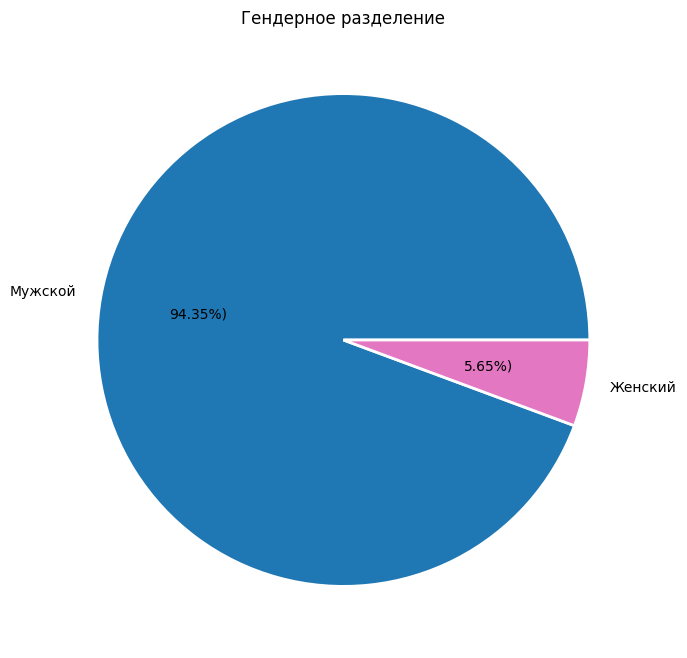

In [260]:
dd = data['gender'].value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:pink', 'yellow'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Гендерное разделение')
plt.show()

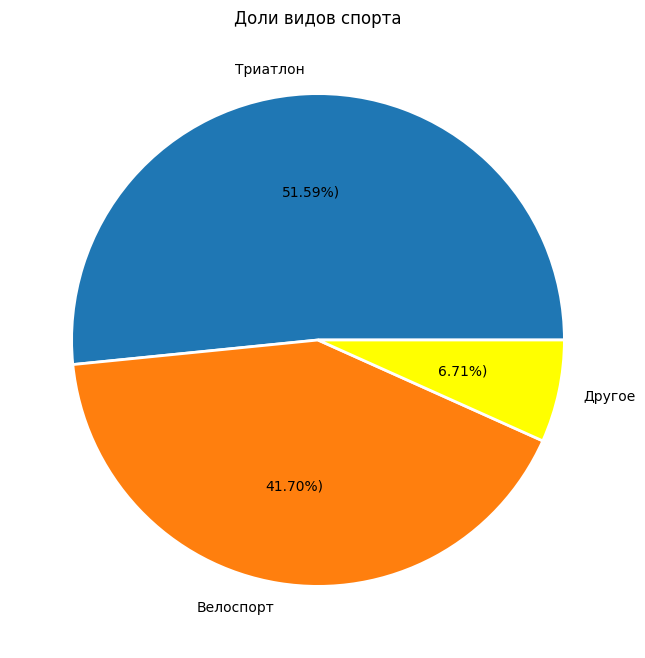

In [261]:
dd = data['sport'].apply(lambda x: 'Другое' if x not in ('Триатлон', 'Велоспорт') else x).value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:orange', 'yellow'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли видов спорта')
plt.show()



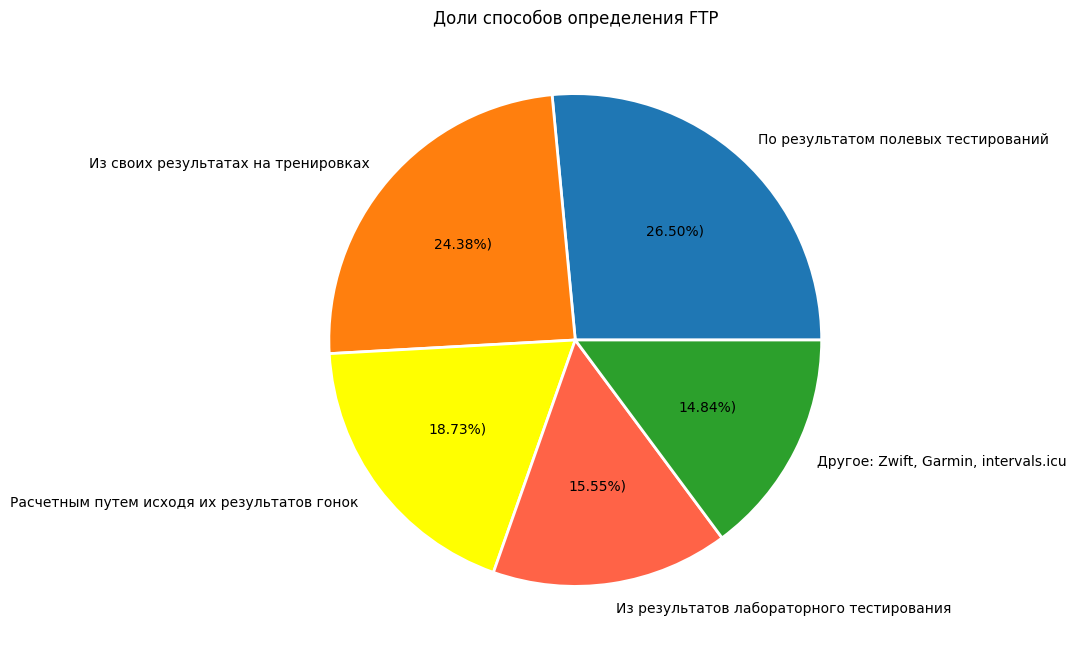

In [262]:
data['ftp_source_c'] = data['ftp_source'].apply(lambda x: 'Другое: Zwift, Garmin, intervals.icu' if x not in (
    'По результатом полевых тестирований',
    'Из своих результатах на тренировках',
    'Расчетным путем исходя их результатов гонок',
    'Из результатов лабораторного тестирования',
    ) else x)

fig = plt.figure(figsize = (15, 8))
plt.pie(x = data['ftp_source_c'].value_counts(), labels = data['ftp_source_c'].value_counts().index, colors = ['tab:blue', 'tab:orange', 'yellow', 'tomato', 'tab:green'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли способов определения FTP')
plt.show()

Стаж можно также считать категориальной функцией

## Статистические харакретистики числовых показателей

In [263]:
train_stat = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
train_stat.loc['Вело тренировки'] = data['bike_minute'].describe()
train_stat.loc['Другие тренировки'] = data['train_minute'].describe()
train_stat.loc['FTP'] = data['ftp_c'].describe()
train_stat.loc['Вес'] = data['weigth_c'].describe()
train_stat.loc['Стаж'] = data['stag_r'].describe()
train_stat

,count,mean,std,min,25%,50%,75%,max
Вело тренировки,283.0,324.707420,195.752525,25.0,180.0,279.0,420.0,1194.0
Другие тренировки,283.0,238.826855,230.508538,0.0,0.0,210.0,397.0,900.0
FTP,283.0,259.222615,46.723078,139.0,225.5,256.0,290.0,402.0
Вес,283.0,75.684806,10.262015,52.0,70.0,76.0,81.0,122.0
Стаж,283.0,53.007067,45.387300,2.0,24.0,40.0,60.0,360.0


Расшифровка
- count - количество спортсменов, по которому расчитаны характеристики
- mean - среднее
- std - стандартное отклонение
- min - минимальное значение
- 25% - первый квантиль - граница 25% значений
- 50% - медиана
- 75% - третий квантиль - граница 75% значений
- max - максимальное значение

Читается так: среднее значение FTP - 261, медианное - 260, минимальное - 158, максимальное - 402. Серединная половина спорстменов имеет FTP от 227 до 293 ватт - такая широкая "золотая середина".

Те же статистические характеристики на графике "ящик с усами"

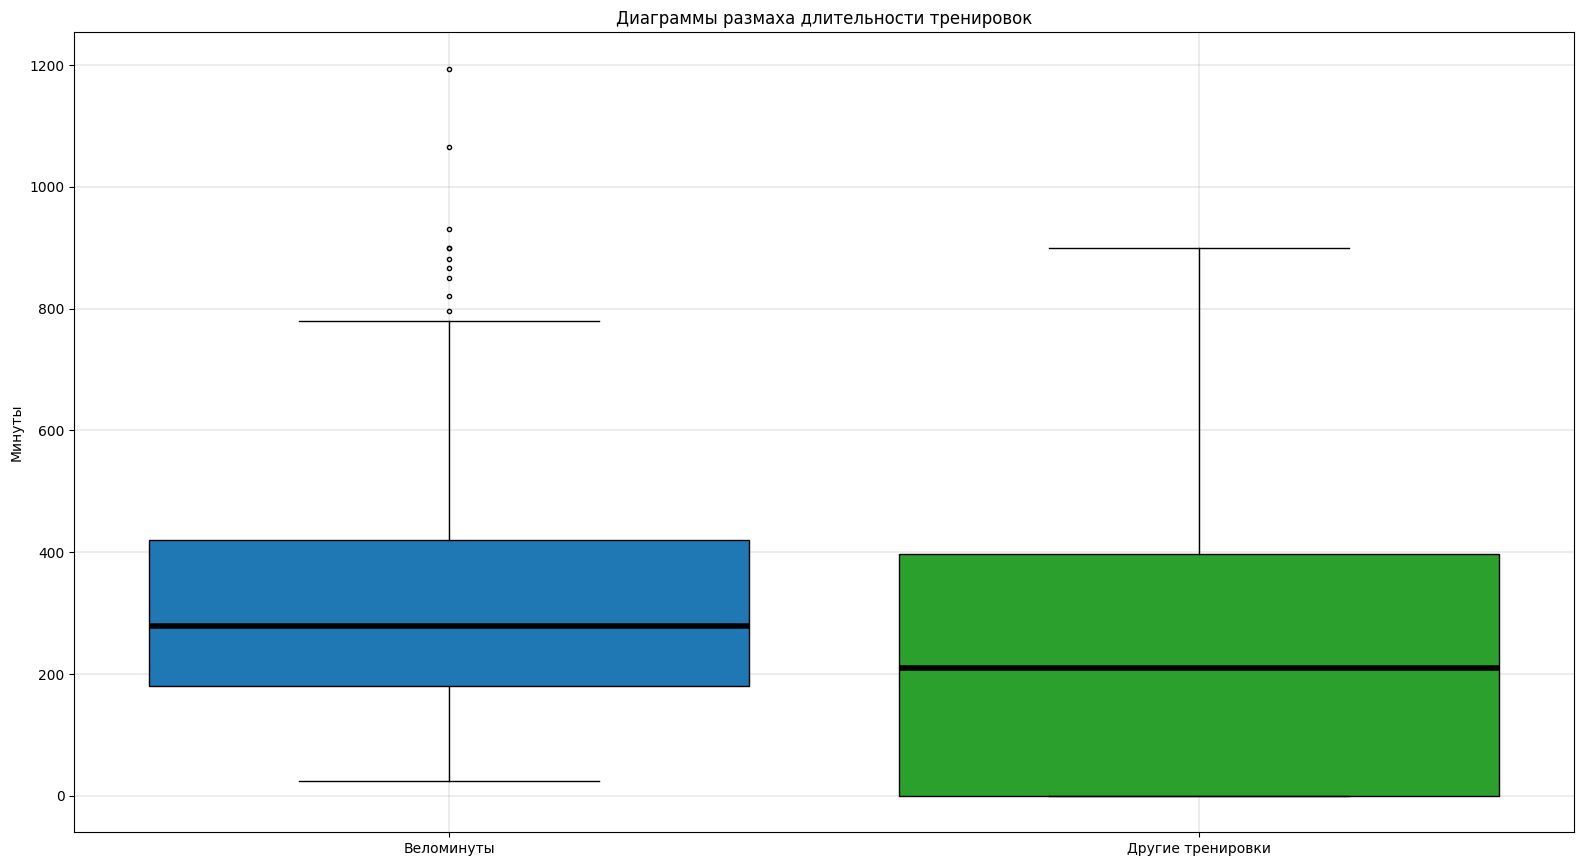

In [264]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(data['bike_minute'], positions=[0], labels = ['Веломинуты'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:blue'), medianprops=dict(color='black', linewidth=4))
ax.boxplot(data['train_minute'], positions=[1], labels = ['Другие тренировки'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:green'), medianprops=dict(color='black', linewidth=4))

plt.title('Диаграммы размаха длительности тренировок')
plt.xlabel('')
plt.ylabel('Минуты')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Закрашенная область - серединная половина, широкая "золотая середина". Толстая  черта в этой области - медиана. Кстати, она необязательно посередине закрашенной области. Верхний ус - граница в 97% спортсменов, нижний ус - 3%. Точки выше или ниже усов считаются "выбросами/аномалиями" и обычно из данных для дальнейшего анализа удаляются.

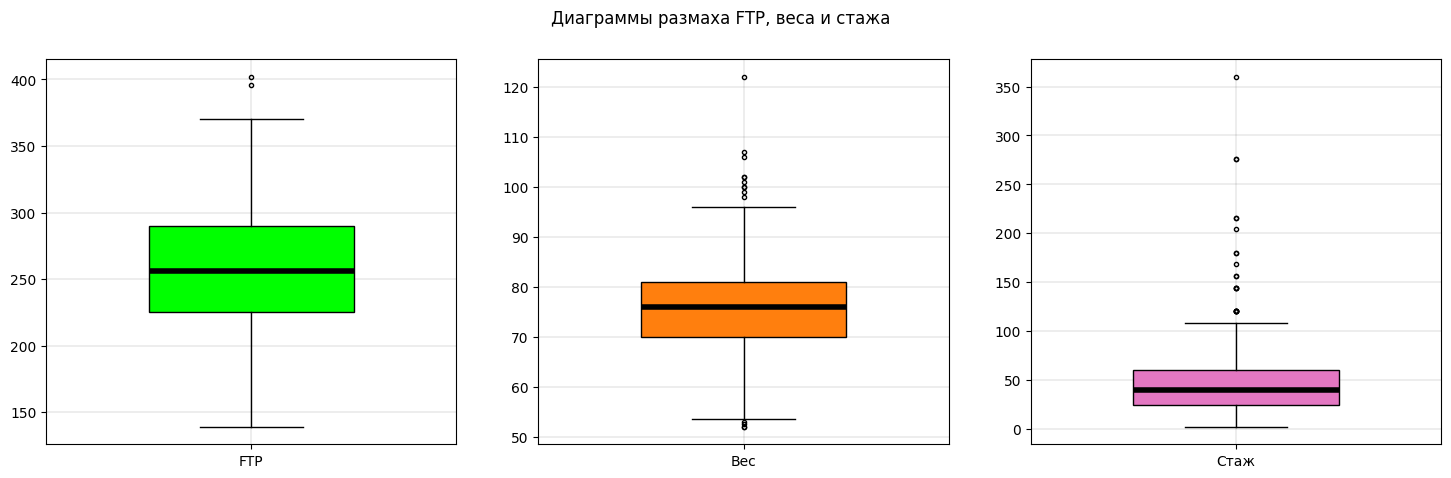

In [265]:
f, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].boxplot(data['ftp_c'], positions=[2], labels = ['FTP'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='lime'), medianprops=dict(color='black', linewidth=4))
ax[0].grid(color='black', linestyle='-', linewidth=0.1)

ax[1].boxplot(data['weigth_c'], positions=[2], labels = ['Вес'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:orange'), medianprops=dict(color='black', linewidth=4))

ax[1].grid(color='black', linestyle='-', linewidth=0.1)

ax[2].boxplot(data['stag_r'], positions=[2], labels = ['Стаж'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:pink'), medianprops=dict(color='black', linewidth=4))
ax[2].grid(color='black', linestyle='-', linewidth=0.1)

plt.suptitle('Диаграммы размаха FTP, веса и стажа')
plt.show()


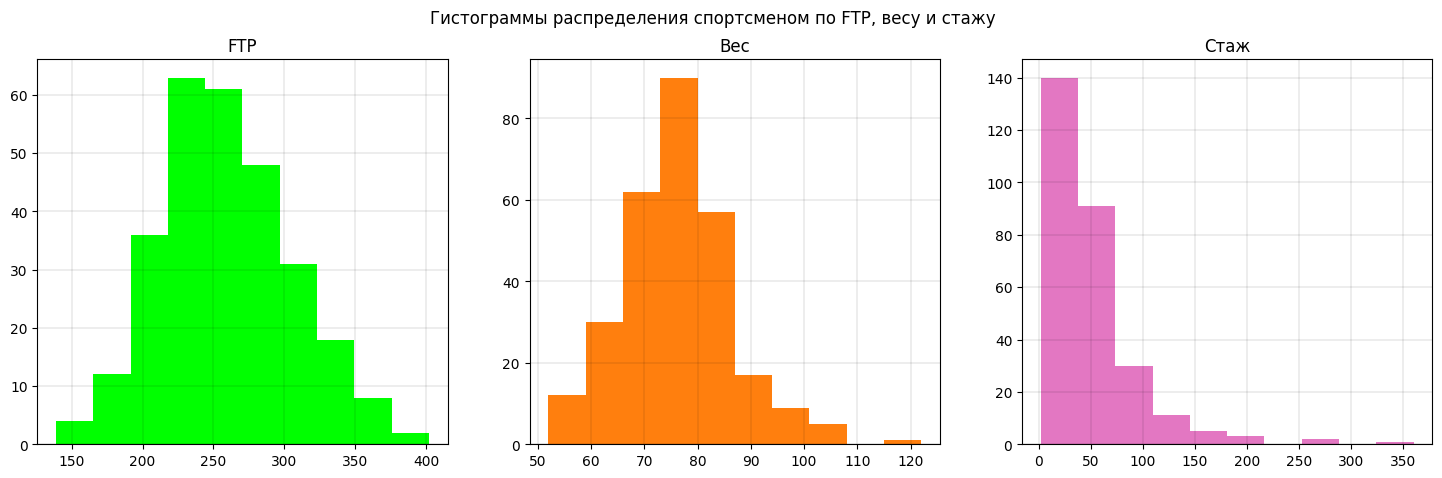

In [266]:
f, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].hist(data['ftp_c'], bins = 10, alpha = 1, color = 'lime')
ax[0].grid(color='black', linestyle='-', linewidth=0.1)
ax[0].set_title('FTP')

ax[1].hist(data['weigth_c'], bins = 10, alpha = 1, color = 'tab:orange')
ax[1].grid(color='black', linestyle='-', linewidth=0.1)
ax[1].set_title('Вес')

ax[2].hist(data['stag_r'], bins = 10, alpha = 1, color = 'tab:pink')
ax[2].grid(color='black', linestyle='-', linewidth=0.1)
ax[2].set_title('Стаж')

plt.suptitle('Гистограммы распределения спортсменом по FTP, весу и стажу')
plt.show()

## Аномалии и выбросы

Зададим верхнюю границу для аномальных значений в 97%

In [267]:
ftp_lim = data['ftp_c'].quantile(0.97)
bike_minute_lim = data['bike_minute'].quantile(0.97)
stag_minute_lim = data['stag_r'].quantile(0.97)

print(f'Верхняя граница нормальных значений FTP {ftp_lim}')
print(f'Верхняя граница нормальных значений веломинут {bike_minute_lim}')
print(f'Верхняя граница нормальных значений стажа {stag_minute_lim}')

Верхняя граница нормальных значений FTP 355.4000000000002
Верхняя граница нормальных значений веломинут 808.9600000000005
Верхняя граница нормальных значений стажа 162.48000000000025


Для дальнейшего анализа отбрасываем аномальные значения / выбросы

In [268]:
data = data.query('ftp_c <= @ftp_lim & stag_r <= @stag_minute_lim & bike_minute <= @bike_minute_lim')

In [269]:
data = data.reset_index(drop = True)

In [270]:
print(f'Дальнейший анализ пройдет на выборке из {len(data)} спорстменов. Изначально было {data_l0}')

Дальнейший анализ пройдет на выборке из 261 спорстменов. Изначально было 283


**Промежуточные итоги**

Рассмотрели распределение категориальных колонок и статистические характеристики числовых колонок. Для дальнейшего анализа убрали данные с выбросами.

# Корреляция FTP, тренировочных минут и веса

Шкала Чеддока для оценки корреляции:

- От 0 до 0,3 — очень слабая
- От 0,3 до 0,5 — слабая
- От 0,5 до 0,7 — средняя
- От 0,7 до 0,9 — сильная (высокая)
- От 0,9 до 1,0 — очень сильная (очень высокая)

Корреляция времени вело тренировок, FTP в ваттах, веса и FTP в ватт/кг методом Пирсена. Зеленым подсвечивается средняя корреляция и выше

In [271]:
data[['bike_minute', 'ftp_c', 'weigth_c', 'ftp_weigth', 'stag_r']].corr(method='pearson').style.apply(highlight_over, color='lime', p=0.5)

,bike_minute,ftp_c,weigth_c,ftp_weigth,stag_r
bike_minute,1.000000,0.391366,-0.179173,0.505544,0.168456
ftp_c,0.391366,1.000000,0.293051,0.684087,0.194610
weigth_c,-0.179173,0.293051,1.000000,-0.480324,-0.148126
ftp_weigth,0.505544,0.684087,-0.480324,1.000000,0.300109
stag_r,0.168456,0.194610,-0.148126,0.300109,1.000000


Между FTP и веломинутами обнаруживается средняя положительная корреляция. Причем в ваттах на килограмм связь сильнее.
Стаж с другими параметрами проявляет очень слабую корреляцию

# Диаграммы рассеяния FTP и веломинут


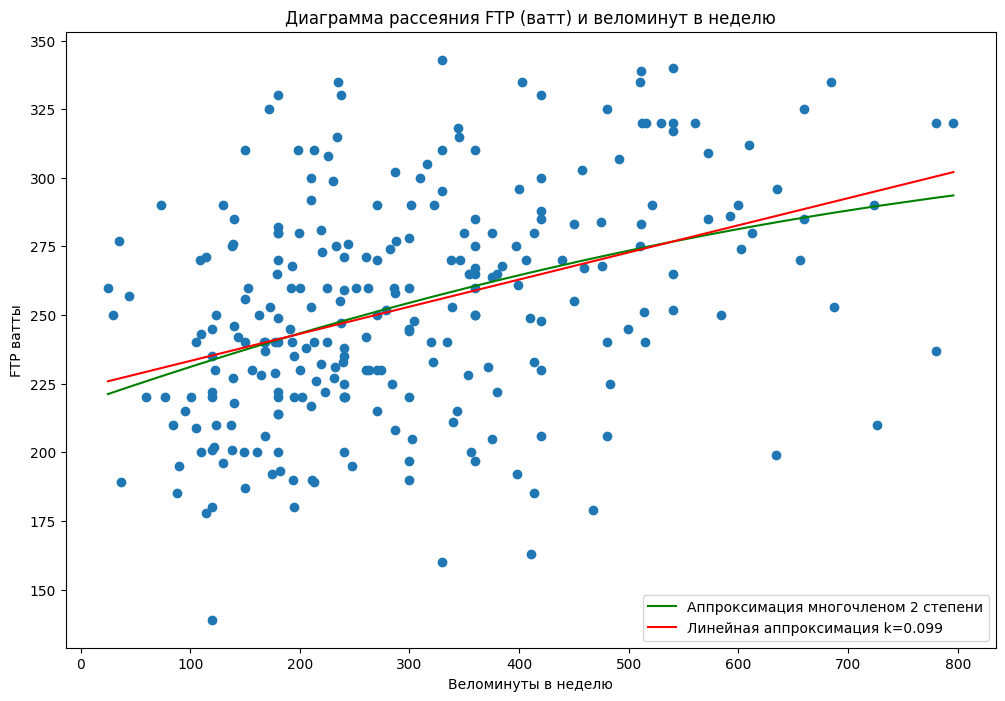

In [272]:
sc = data[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')
plt.figure(figsize=(12,8))
plt.scatter(sc['bike_minute'], sc['ftp_c'])

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], 2)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='green', label = 'Аппроксимация многочленом 2 степени')

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], 1)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='red', label = f'Линейная аппроксимация k={round(z[0], 3)}')

plt.title('Диаграмма рассеяния FTP (ватт) и веломинут в неделю')
plt.ylabel('FTP ватты')
plt.xlabel('Веломинуты в неделю')
plt.legend()
plt.show()

In [273]:
print(f'Коэффициент линиейной аппроксимации FTP и веломинут: {round(z[0], 3)}')
print(f'Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на {round(z[0] * 60, 3)} ватт')

Коэффициент линиейной аппроксимации FTP и веломинут: 0.099
Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на 5.93 ватт


Однако, при этом данные, хорошо аппоксимируются и квадратичной фукнцией, которая показывает уменьшающийся прирост на больших веломинутах

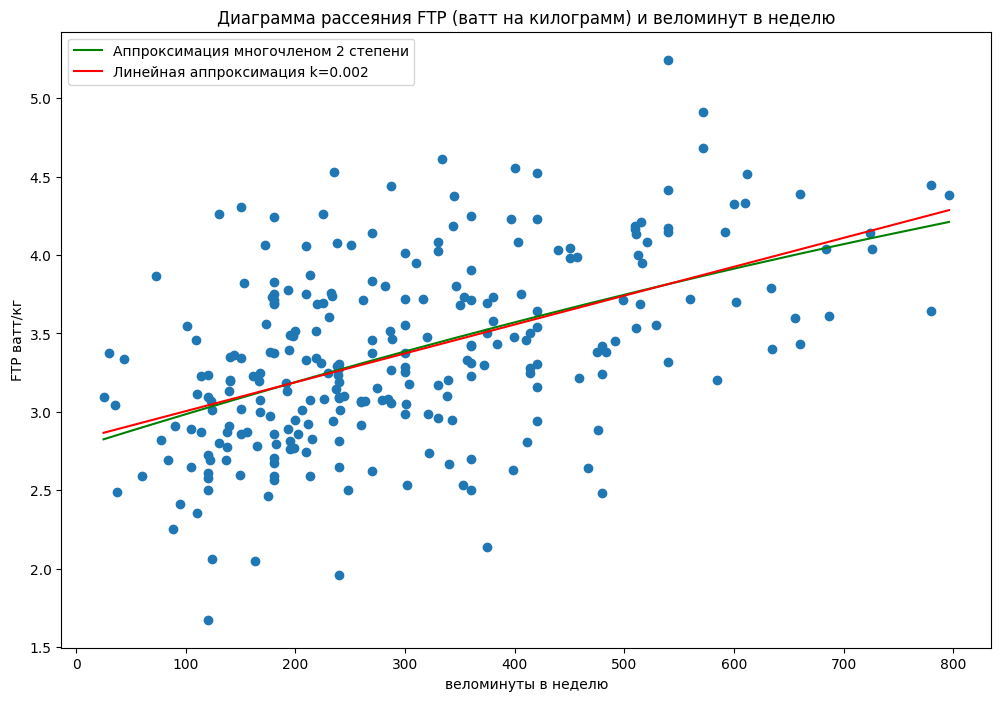

In [274]:
sc = data[['bike_minute', 'ftp_weigth']].sort_values(by='bike_minute')
plt.figure(figsize=(12,8))
plt.scatter(sc['bike_minute'], sc['ftp_weigth'])

z = np.polyfit(sc['bike_minute'], sc['ftp_weigth'], 2)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='green', label = 'Аппроксимация многочленом 2 степени')

z = np.polyfit(sc['bike_minute'], sc['ftp_weigth'], 1)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='red', label = f'Линейная аппроксимация k={round(z[0], 3)}')

plt.title('Диаграмма рассеяния FTP (ватт на килограмм) и веломинут в неделю')
plt.ylabel('FTP ватт/кг')
plt.xlabel('веломинуты в неделю')
plt.legend()
plt.show()

In [275]:
print(f'Коэффициент линиейной аппроксимации FTP и веломинут: {round(z[0], 3)}')
print(f'Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на {round(z[0] * 60, 3)} ватт/кг')

Коэффициент линиейной аппроксимации FTP и веломинут: 0.002
Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на 0.111 ватт/кг


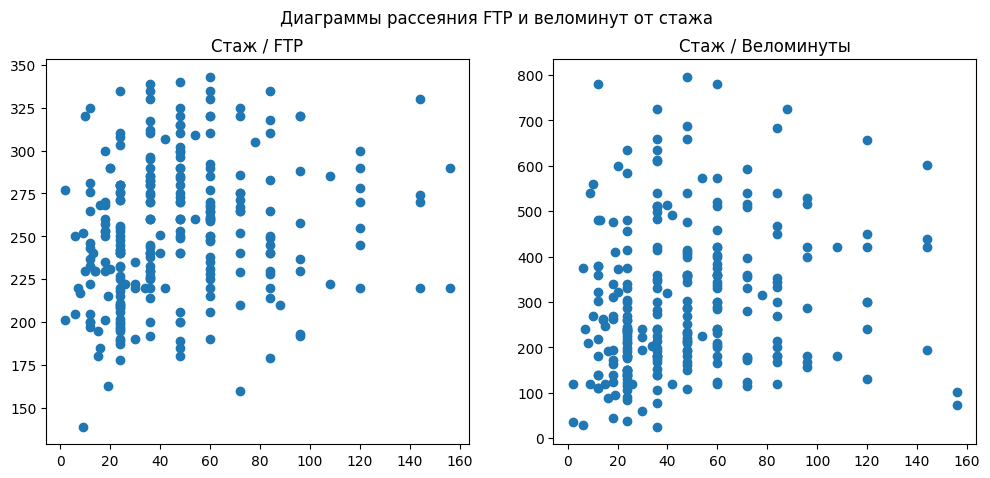

In [276]:
f, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].scatter(data['stag_r'], data['ftp_c'])
ax[0].set_title('Стаж / FTP')
ax[1].scatter(data['stag_r'], data['bike_minute'])
ax[1].set_title('Стаж / Веломинуты')
plt.suptitle('Диаграммы рассеяния FTP и веломинут от стажа')
plt.show()

Каких-то зависимостей от стажа из диаграмы расеяния не обнаруживается

**Промежутояный итог**

Между веломинутами и FTP обнаруживается средняя положительная корреляция. Коэффициент линиейной взаимосвзяли 0.099

# Когортный анализ

### Когорты по FTP

Разделим спортменов на когорты **по указанному FTP** - от 190 до 330+ с шагом в 20 ватт

In [277]:
ftp_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
ftp_stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))

qstr_last = ''
ftpbox = dict()
data['ch_ftp'] = 'FTP999'
for i in range(190, 350, 20):
    qstr = qstr_last + 'ftp_c <= ' + str(i+1)
    print(f'Условие для отбора когорты {i}: {qstr}')
    ftpbox[i]= data.query(qstr)[['bike_minute', 'stag_r']]
    ch_index = data.query(qstr).index
    data.loc[ch_index, 'ch_ftp'] = 'FTP' + str(i)
    ftp_describe.loc[i] = ftpbox[i]['bike_minute'].describe()
    ftp_stag_describe.loc[i] = ftpbox[i]['stag_r'].describe()
    qstr_last =  str(i+1) + ' < '
ftpbox[999]= data.query('330+1 < ftp_c')[['bike_minute', 'stag_r']]
ftp_describe.loc[999] = ftpbox[999]['bike_minute'].describe()
ftp_stag_describe.loc[999] = ftpbox[999]['stag_r'].describe()
print(f'Условие для отбора когорты {999}: 331 < ftp_c')

Условие для отбора когорты 190: ftp_c <= 191
Условие для отбора когорты 210: 191 < ftp_c <= 211
Условие для отбора когорты 230: 211 < ftp_c <= 231
Условие для отбора когорты 250: 231 < ftp_c <= 251
Условие для отбора когорты 270: 251 < ftp_c <= 271
Условие для отбора когорты 290: 271 < ftp_c <= 291
Условие для отбора когорты 310: 291 < ftp_c <= 311
Условие для отбора когорты 330: 311 < ftp_c <= 331
Условие для отбора когорты 999: 331 < ftp_c


`Таблица статиcтичеcких характеристик когорт. Индекс - верхняя граница когорты`

In [278]:
ftp_cohorts_stat = pd.merge(ftp_describe, ftp_stag_describe, how = 'left', left_index=True, right_index=True, suffixes=('_minute', '_stag'))
ftp_cohorts_stat

,count_minute,mean_minute,std_minute,min_minute,25%_minute,50%_minute,75%_minute,max_minute,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
190,15.0,224.266667,131.429757,37.0,120.00,195.0,315.00,467.0,15.0,36.333333,22.483857,9.0,21.5,24.0,48.0,84.0
210,30.0,254.700000,161.187436,84.0,131.75,181.0,352.00,726.0,30.0,33.500000,25.510985,2.0,19.5,24.0,45.0,96.0
230,41.0,222.780488,93.434338,60.0,165.00,215.0,270.00,483.0,41.0,48.487805,36.928391,7.0,24.0,36.0,60.0,156.0
250,46.0,269.347826,148.417612,30.0,168.00,231.5,330.75,780.0,46.0,42.717391,26.380686,6.0,24.0,36.0,60.0,120.0
270,45.0,304.600000,144.160643,25.0,200.00,286.0,380.00,687.0,45.0,50.022222,30.171095,9.0,24.0,48.0,60.0,144.0
290,40.0,349.955000,176.043669,35.0,214.00,336.0,483.75,724.0,40.0,52.350000,36.119140,2.0,24.0,42.0,63.0,156.0
310,19.0,333.947368,133.918911,150.0,219.50,316.0,410.00,635.0,19.0,49.263158,24.460494,18.0,36.0,48.0,57.0,120.0
330,18.0,469.777778,187.845542,172.0,344.25,514.0,555.00,796.0,18.0,59.222222,32.184314,10.0,39.0,54.0,72.0,144.0
999,7.0,459.000000,148.573214,235.0,366.50,510.0,525.50,684.0,7.0,49.714286,20.113961,24.0,36.0,48.0,60.0,84.0


Диаграммы размаха когорт

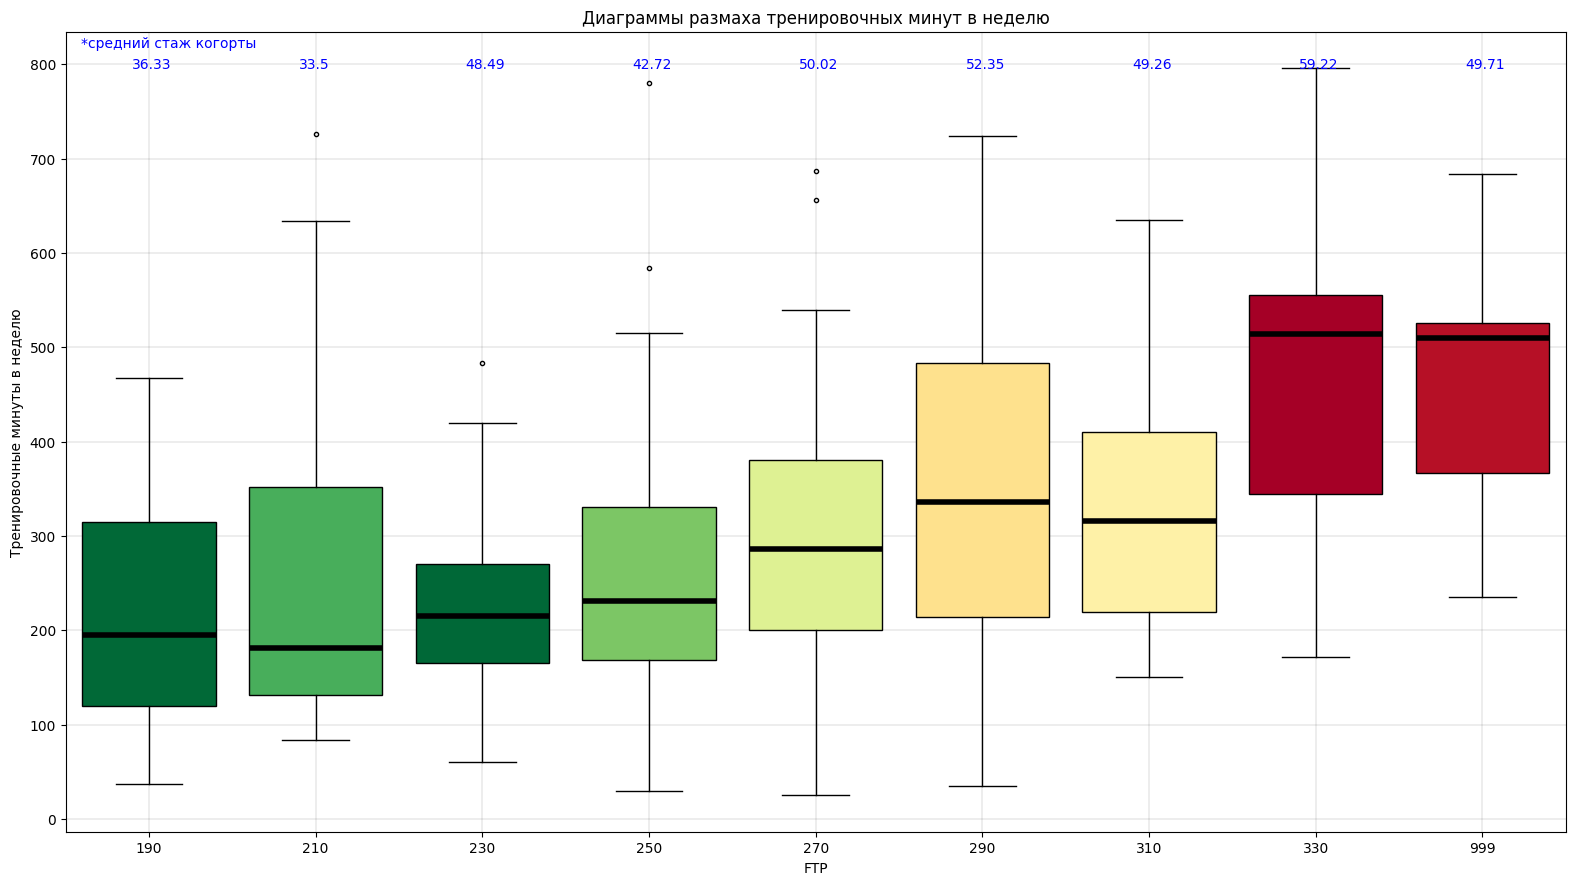

In [279]:
c = gradient_by_value(ftp_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for fb in ftpbox:
    ax.boxplot(ftpbox[fb]['bike_minute'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, ftp_describe['max'].max(), f"{round(ftp_stag_describe.loc[fb, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средний стаж когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха тренировочных минут в неделю')
plt.xlabel('FTP')
plt.ylabel('Тренировочные минуты в неделю')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Цвет тела середины "ящика с усами" определяется нормировкой среднего значения когорты по трехцветному градиенту, где красный - маскимальное среднее значение целевого показателя среди всех когорт, зеленый - минмальное значние, желтый - среднее значение.

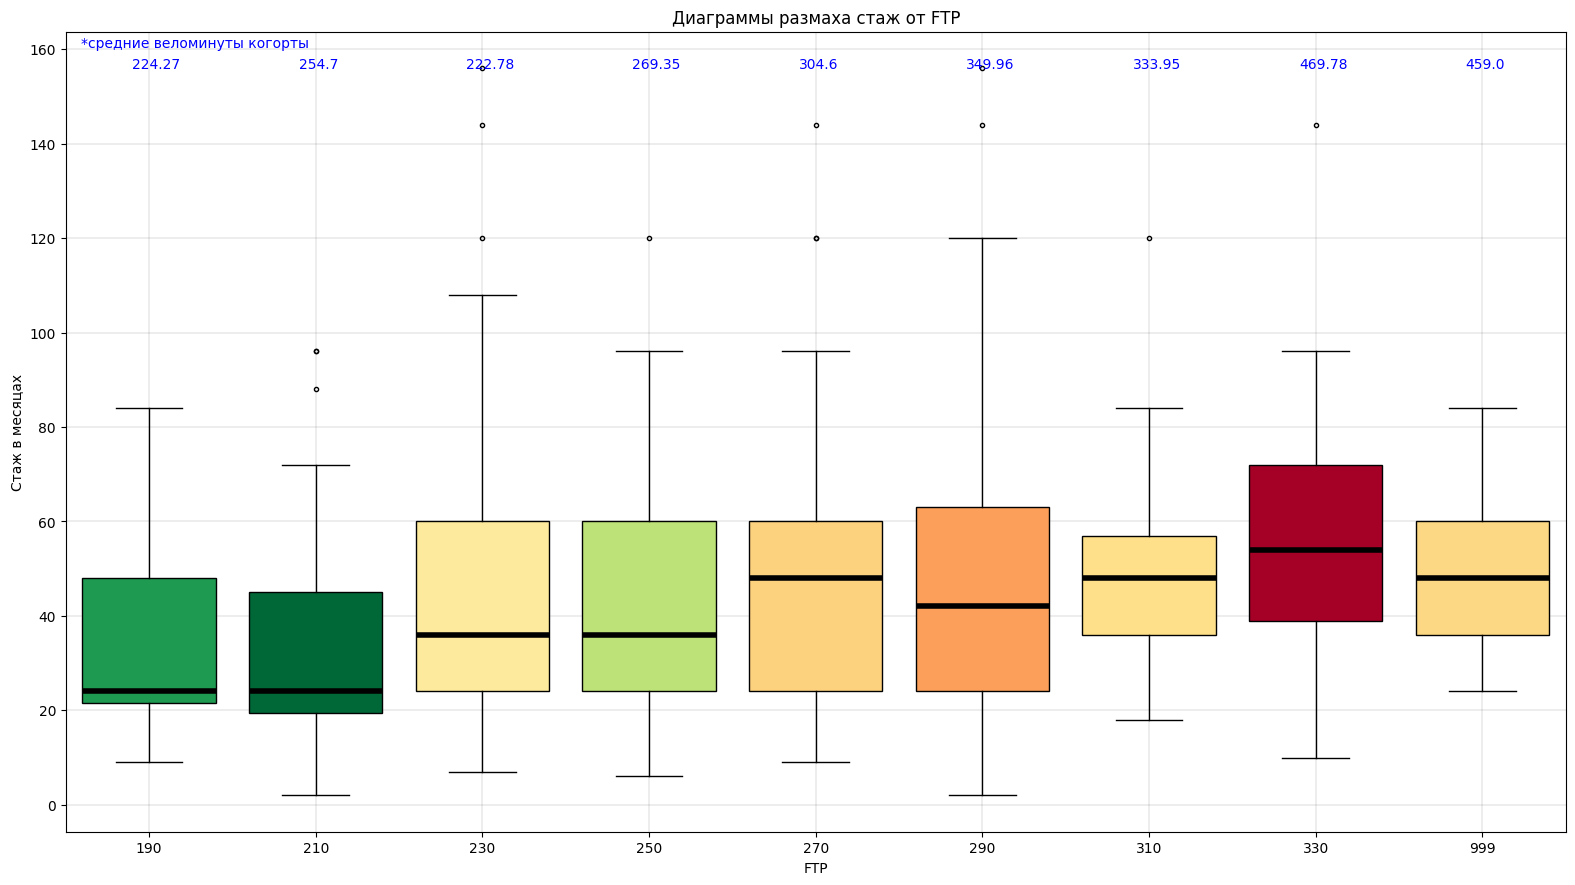

In [280]:
c = gradient_by_value(ftp_stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for fb in ftpbox:
    ax.boxplot(ftpbox[fb]['stag_r'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, ftp_stag_describe['max'].max(), f"{round(ftp_describe.loc[fb, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средние веломинуты когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха стаж от FTP')
plt.xlabel('FTP')
plt.ylabel('Стаж в месяцах')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

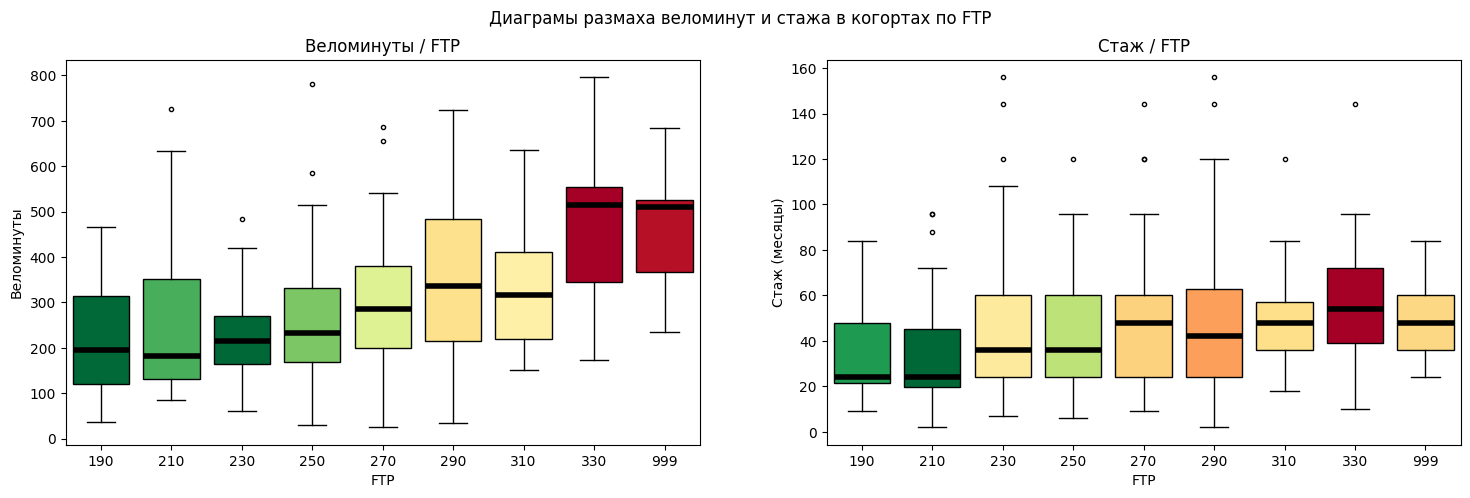

In [281]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(ftp_describe['mean'])
i = 0
for fb in ftpbox:
    ax[0].boxplot(ftpbox[fb]['bike_minute'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('Веломинуты / FTP')
ax[0].set_xlabel('FTP')
ax[0].set_ylabel('Веломинуты')


c = gradient_by_value(ftp_stag_describe['mean'])
i = 0
for fb in ftpbox:
    ax[1].boxplot(ftpbox[fb]['stag_r'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Стаж / FTP')
ax[1].set_xlabel('FTP')
ax[1].set_ylabel('Стаж (месяцы)')

plt.suptitle('Диаграмы размаха веломинут и стажа в когортах по FTP')
plt.show()



В когортах по FTP проявляется взаимосвязь с веломинутами. Чем больше FTP, тем большие веломинуты указывали спорстмены в опросе. А вот со стажей связи както не просматриватеся. Во всех когортах по FTP вполне сопоставимые значения тренировочного стажа.

### Когорты по веломинутам

Разделим спортменов на когорты **по веломинутам** в минутах - от 60 до 600+ с шагом в 60

In [282]:
bikeminut_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
bikeminut_stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
data['ch_bm'] = 'веломин999'
qstr_last = ''
bikeminutbox = dict()
for i in range(120, 600, 60):
    qstr = qstr_last + 'bike_minute <= ' + str(i+1)
    print(f'Условие для отбора когорты {i}: {qstr}')
    bikeminutbox[i] = data.query(qstr)[['ftp_c', 'stag_r']]
    ch_index = data.query(qstr).index
    data.loc[ch_index, 'ch_bm'] = 'веломин' + str(i)
    qstr_last =  str(i+1) + ' < '
    bikeminut_describe.loc[i] = bikeminutbox[i]['ftp_c'].describe()
    bikeminut_stag_describe.loc[i] = bikeminutbox[i]['stag_r'].describe()
bikeminutbox[999]= data.query('540+1 < bike_minute')[['ftp_c', 'stag_r']]
bikeminut_describe.loc[999] = bikeminutbox[999]['ftp_c'].describe()
bikeminut_stag_describe.loc[999] = bikeminutbox[999]['stag_r'].describe()
print(f'Условие для отбора когорты {999}: 541 < bike_minute')

Условие для отбора когорты 120: bike_minute <= 121
Условие для отбора когорты 180: 121 < bike_minute <= 181
Условие для отбора когорты 240: 181 < bike_minute <= 241
Условие для отбора когорты 300: 241 < bike_minute <= 301
Условие для отбора когорты 360: 301 < bike_minute <= 361
Условие для отбора когорты 420: 361 < bike_minute <= 421
Условие для отбора когорты 480: 421 < bike_minute <= 481
Условие для отбора когорты 540: 481 < bike_minute <= 541
Условие для отбора когорты 999: 541 < bike_minute


`Таблица статиcтичеcких характеристик когорт. Индекс - верхняя граница когорты`

In [283]:
bikeminute_cohorts_stat = pd.merge(bikeminut_describe, bikeminut_stag_describe, how = 'left', left_index=True, right_index=True, suffixes=('_ftp', '_stag'))
bikeminute_cohorts_stat

,count_ftp,mean_ftp,std_ftp,min_ftp,25%_ftp,50%_ftp,75%_ftp,max_ftp,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
120,27.0,223.740741,35.228477,139.0,200.50,220.0,247.50,290.0,27.0,37.518519,39.466023,2.0,15.5,24.0,39.0,156.0
180,47.0,241.425532,34.823621,187.0,214.00,240.0,262.50,330.0,47.0,43.914894,27.950134,12.0,24.0,36.0,60.0,120.0
240,50.0,248.740000,38.149443,180.0,222.75,240.0,272.50,335.0,50.0,43.180000,26.637161,7.0,24.0,36.0,52.5,144.0
300,30.0,247.633333,29.643262,190.0,230.00,251.0,270.75,302.0,30.0,46.566667,30.449147,10.0,24.0,42.0,60.0,120.0
360,32.0,261.031250,41.546309,160.0,238.25,265.0,291.25,343.0,32.0,46.687500,22.835227,12.0,24.0,48.0,60.0,84.0
420,25.0,254.440000,43.333090,163.0,230.00,264.0,280.00,335.0,25.0,55.080000,35.482296,6.0,24.0,48.0,60.0,144.0
480,11.0,261.818182,41.542311,179.0,247.50,268.0,283.50,325.0,11.0,57.363636,45.546180,12.0,21.0,48.0,84.0,144.0
540,18.0,291.333333,37.671959,225.0,255.25,298.5,320.00,340.0,18.0,53.722222,24.028918,9.0,36.0,45.0,72.0,96.0
999,21.0,283.142857,36.827009,199.0,270.00,286.0,312.00,335.0,21.0,52.190476,34.075826,10.0,36.0,48.0,60.0,144.0


Диаграммы размаха когорт

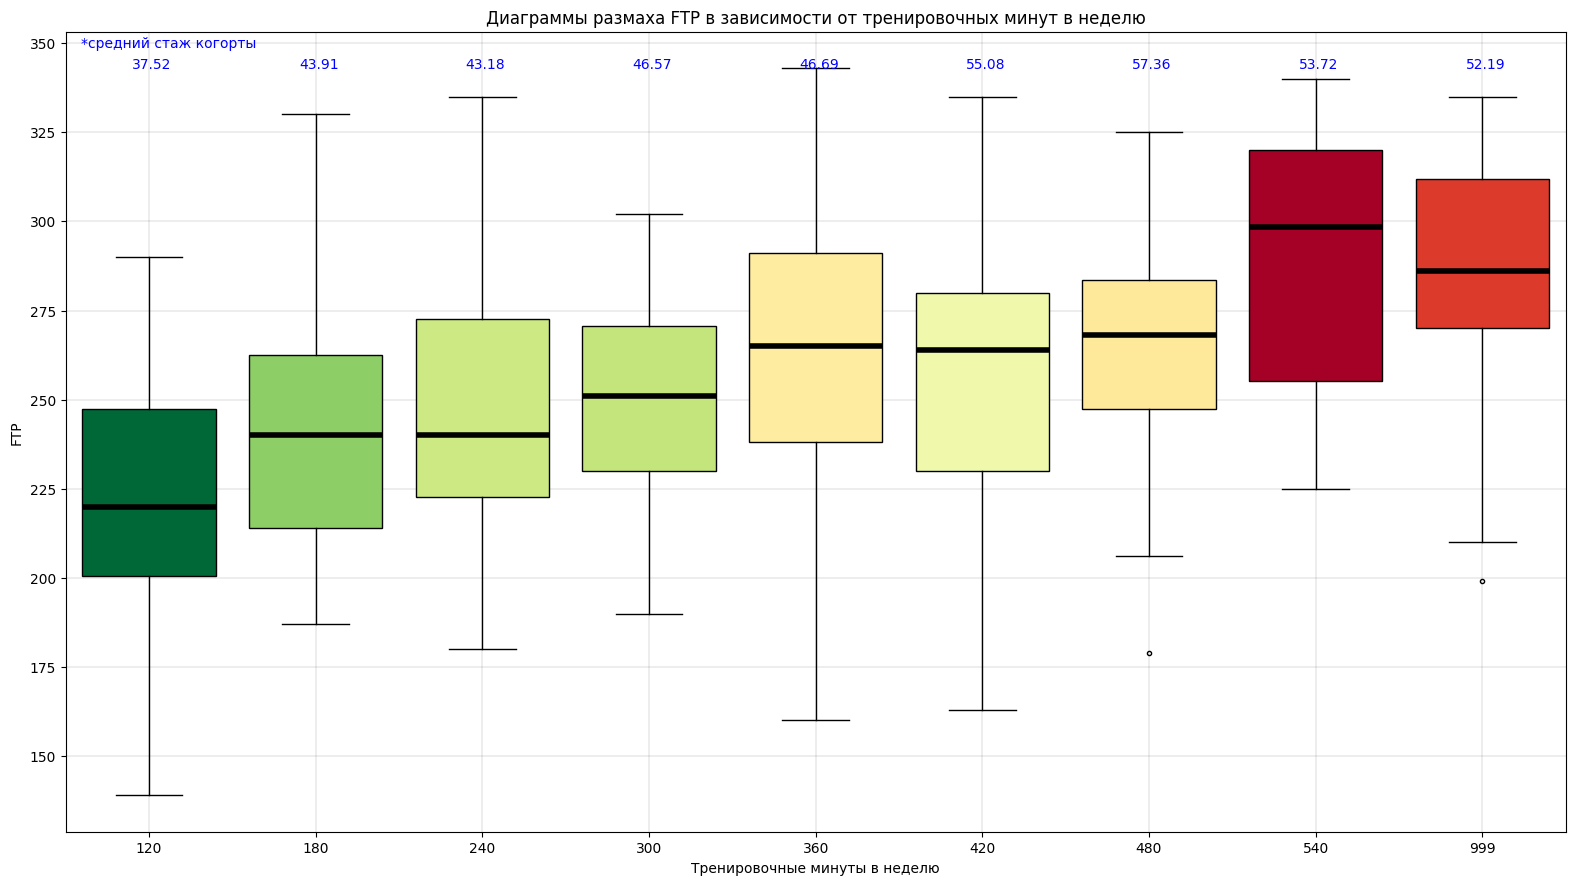

In [284]:
c = gradient_by_value(bikeminut_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in bikeminutbox:
    ax.boxplot(bikeminutbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, bikeminut_describe['max'].max(), f"{round(bikeminut_stag_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средний стаж когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха FTP в зависимости от тренировочных минут в неделю')
plt.xlabel('Тренировочные минуты в неделю')
plt.ylabel('FTP')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

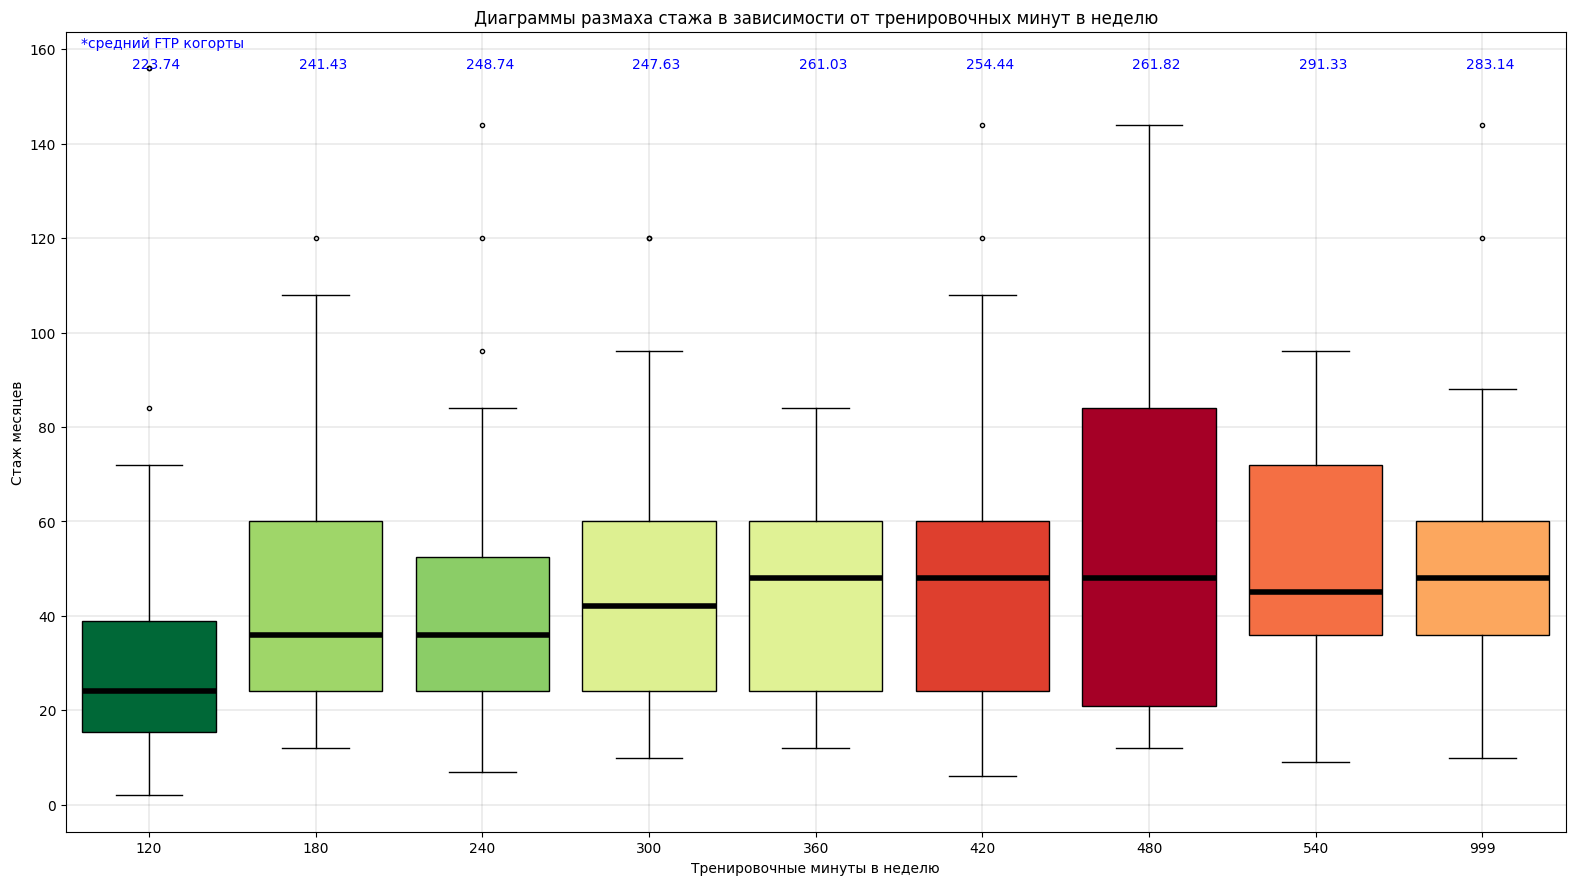

In [285]:
c = gradient_by_value(bikeminut_stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in bikeminutbox:
    ax.boxplot(bikeminutbox[bk]['stag_r'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, bikeminut_stag_describe['max'].max(), f"{round(bikeminut_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средний FTP когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха стажа в зависимости от тренировочных минут в неделю')
plt.xlabel('Тренировочные минуты в неделю')
plt.ylabel('Стаж месяцев')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

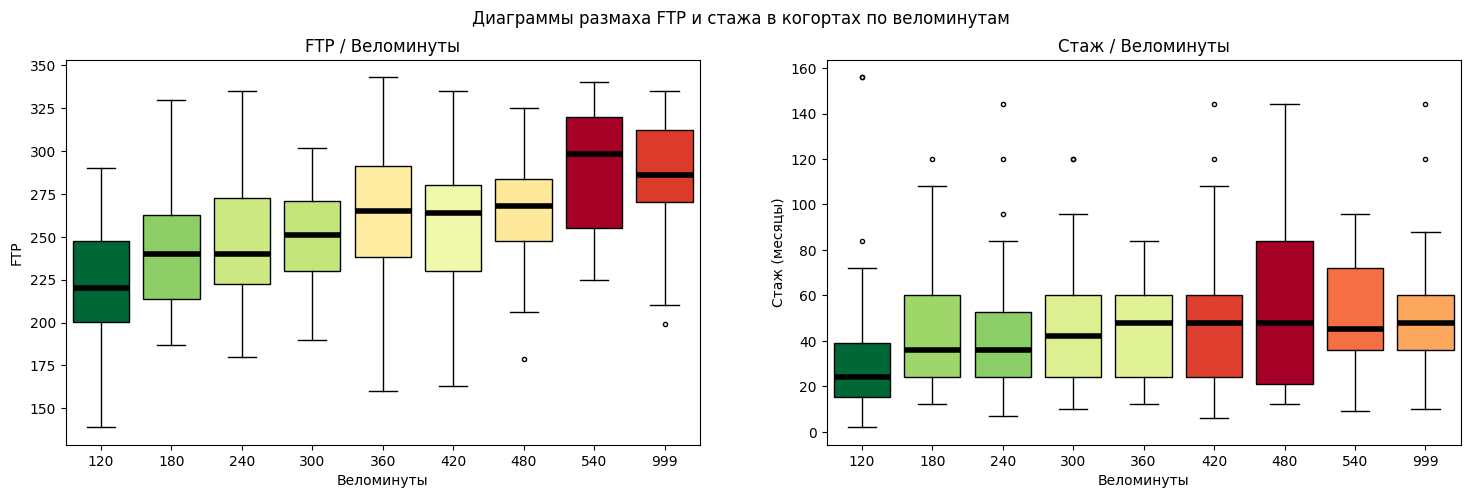

In [286]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(bikeminut_describe['mean'])
i = 0
for bk in bikeminutbox:
    ax[0].boxplot(bikeminutbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('FTP / Веломинуты')
ax[0].set_xlabel('Веломинуты')
ax[0].set_ylabel('FTP')


c = gradient_by_value(bikeminut_stag_describe['mean'])
i = 0
for bk in bikeminutbox:
    ax[1].boxplot(bikeminutbox[bk]['stag_r'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Стаж / Веломинуты')
ax[1].set_xlabel('Веломинуты')
ax[1].set_ylabel('Стаж (месяцы)')

plt.suptitle('Диаграммы размаха FTP и стажа в когортах по веломинутам')
plt.show()

В когортах также прослеживается взаимосязь роста веломинут с ростом FTP. Примечательно, что не просматривется связи роста веломинут со стажем.

### Когорты по тренирочному стажу

Разделим спортменов на когорты **по тренировочному стажу** в месяцах - от 18 до 90+ с шагом в 12

In [287]:
stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
stag_ftp_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
data['ch_st'] = 'стаж999'
qstr_last = ''
stagbox = dict()
for i in range(18, 100, 12):
    qstr = qstr_last + 'stag_r <= ' + str(i+1)
    #print(qstr)
    stagbox[i]= data.query(qstr)[['bike_minute', 'ftp_c']]
    stag_describe.loc[i] = stagbox[i]['bike_minute'].describe()
    stag_ftp_describe.loc[i] = stagbox[i]['ftp_c'].describe()
    ch_index = data.query(qstr).index
    data.loc[ch_index, 'ch_st'] = 'стаж' + str(i)
    qstr_last =  str(i+1) + ' < '
stagbox[999]= data.query('90+1 < stag_r')[['bike_minute', 'ftp_c']]
stag_describe.loc[999] = stagbox[999]['bike_minute'].describe()
stag_ftp_describe.loc[999] = stagbox[999]['ftp_c'].describe()

In [288]:
stag_cohorts_stat = pd.merge(stag_describe, stag_ftp_describe, how = 'left', left_index=True, right_index=True, suffixes=('_minute', '_ftp'))
stag_cohorts_stat

,count_minute,mean_minute,std_minute,min_minute,25%_minute,50%_minute,75%_minute,max_minute,count_ftp,mean_ftp,std_ftp,min_ftp,25%_ftp,50%_ftp,75%_ftp,max_ftp
18,43.0,257.051163,160.457733,30.0,130.50,241.0,349.50,780.0,43.0,235.441860,38.689424,139.0,205.00,235.0,258.50,325.0
30,54.0,238.981481,130.435047,37.0,149.25,221.0,282.75,634.0,54.0,237.722222,37.028503,178.0,209.25,232.5,267.25,335.0
42,43.0,327.604651,180.428609,25.0,180.00,282.0,495.00,724.0,43.0,262.093023,37.202671,192.0,231.50,260.0,285.00,339.0
54,35.0,327.714286,163.444463,109.0,213.00,286.0,403.00,796.0,35.0,268.000000,42.483215,180.0,249.50,273.0,299.50,340.0
66,32.0,333.218750,139.587811,120.0,236.50,334.0,400.00,780.0,32.0,264.343750,38.419257,190.0,237.25,260.5,286.25,343.0
78,15.0,330.600000,157.750164,114.0,178.00,330.0,453.50,592.0,15.0,263.000000,42.245879,160.0,246.00,267.0,280.50,325.0
90,16.0,345.562500,183.793351,120.0,195.00,317.0,454.25,726.0,16.0,251.000000,42.185305,179.0,226.00,242.5,269.50,335.0
999,23.0,329.652174,166.125256,73.0,181.00,300.0,429.50,656.0,23.0,261.173913,39.678999,192.0,226.00,270.0,289.00,330.0


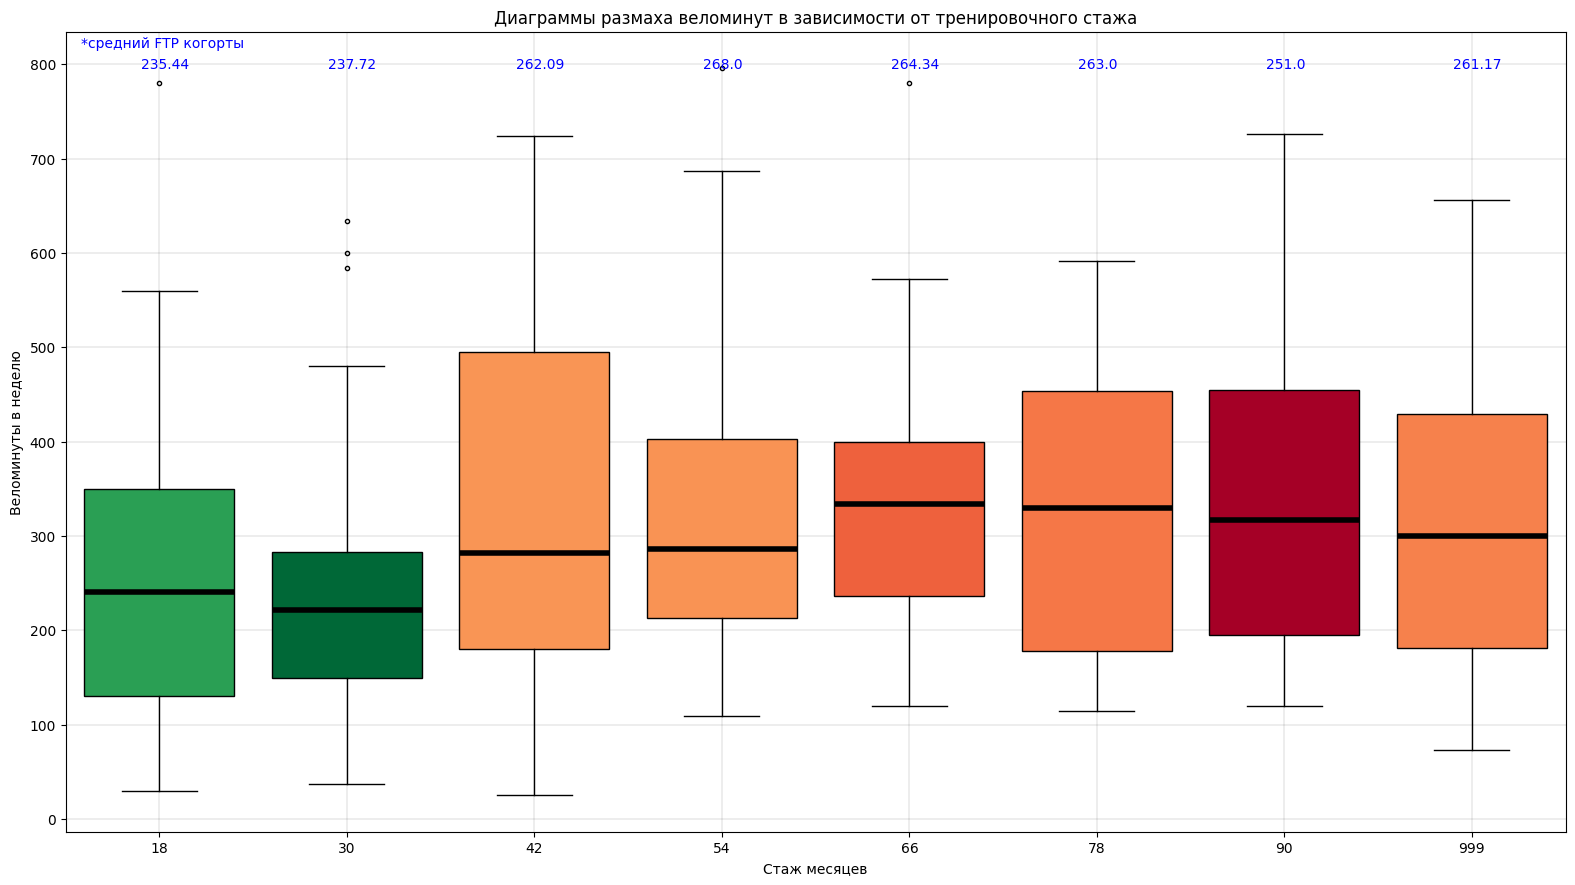

In [289]:
c = gradient_by_value(stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in stagbox:
    ax.boxplot(stagbox[bk]['bike_minute'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, stag_describe['max'].max(), f"{round(stag_ftp_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средний FTP когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха веломинут в зависимости от тренировочного стажа')
plt.xlabel('Стаж месяцев')
plt.ylabel('Веломинуты в неделю')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

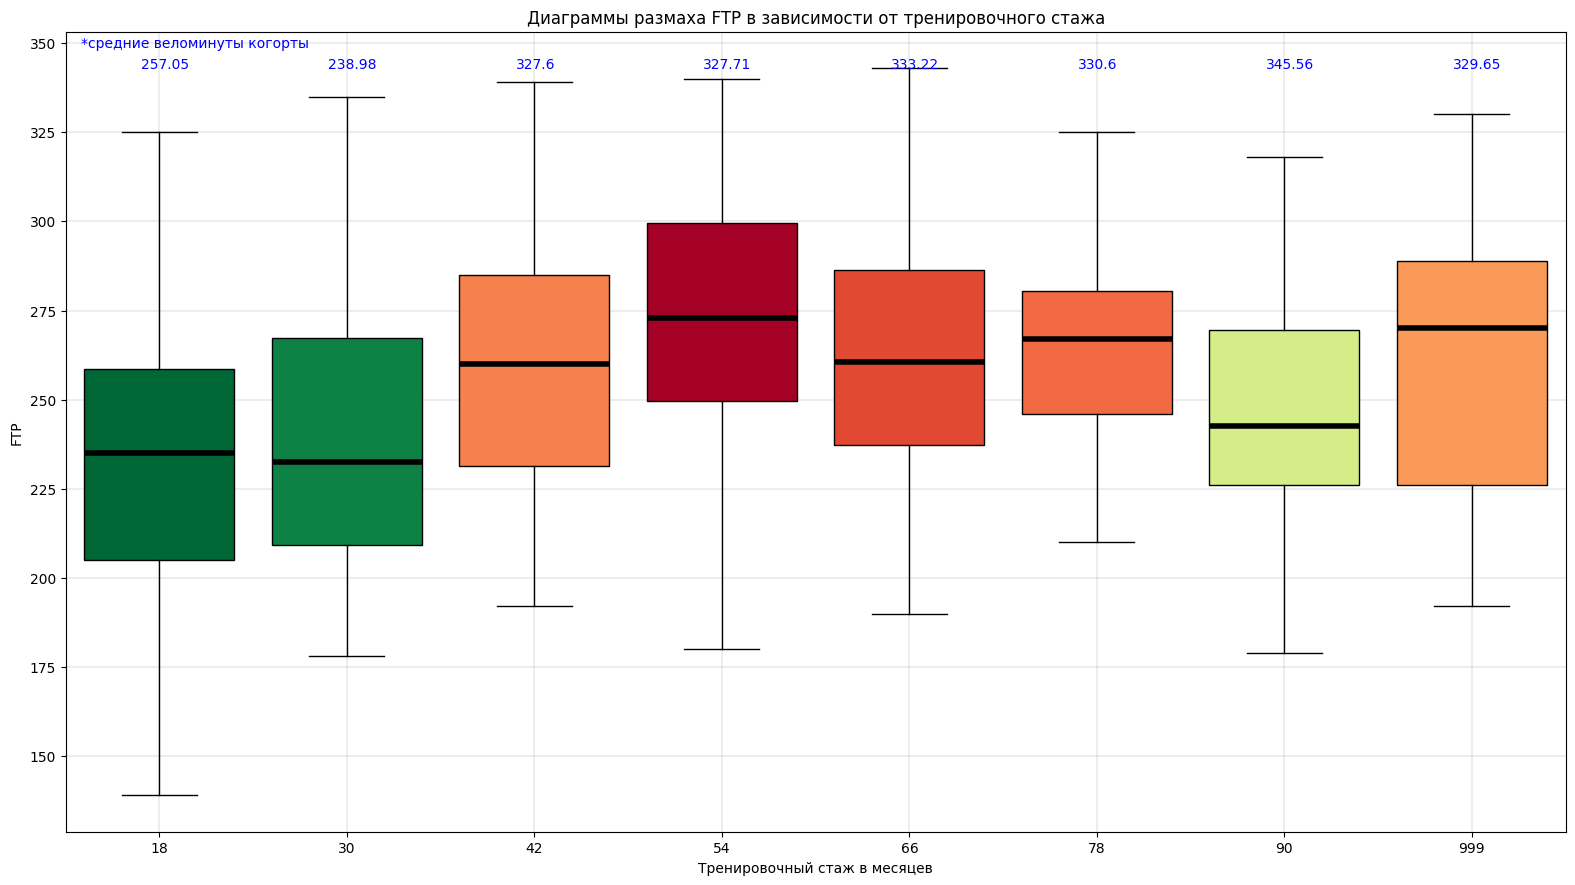

In [290]:
c = gradient_by_value(stag_ftp_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in stagbox:
    ax.boxplot(stagbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, stag_ftp_describe['max'].max(), f"{round(stag_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средние веломинуты когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха FTP в зависимости от тренировочного стажа')
plt.xlabel('Тренировочный стаж в месяцев')
plt.ylabel('FTP')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

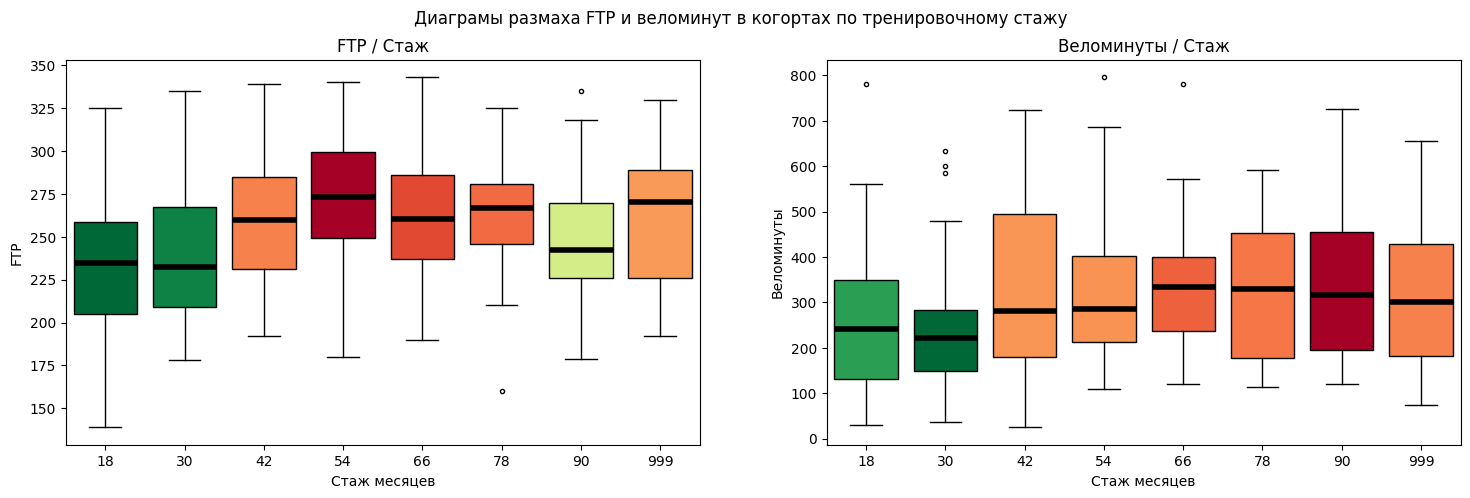

In [291]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(stag_ftp_describe['mean'])
i = 0
for bk in stagbox:
    ax[0].boxplot(stagbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('FTP / Стаж')
ax[0].set_xlabel('Стаж месяцев')
ax[0].set_ylabel('FTP')


c = gradient_by_value(stag_describe['mean'])
i = 0
for bk in stagbox:
    ax[1].boxplot(stagbox[bk]['bike_minute'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Веломинуты / Стаж')
ax[1].set_xlabel('Стаж месяцев')
ax[1].set_ylabel('Веломинуты')

plt.suptitle('Диаграмы размаха FTP и веломинут в когортах по тренировочному стажу')
plt.show()

Данные говорят, что наибольший уровень FTP показываюи спорсмены на 3-6 годы тренировок. После этого значения FTP немного падают.

У новичков меньше всего веломинут. С ростом стажа веломинуты стабилизируются примерно на уровне 300-400 минут в неделю.

Только единицы, видимо, остающиеся в спорте высоких достижений, продолжают поддерживать или наращивать объемы тренировок и показывать высокие FTP.

## Пересечение когорт

"Тепловая карта" количества спортсменов в координатах FTP / веломинут. По горизонтали когорты FTP, по вертиками когорты веломинут. В ячейках - количество спортсменов, которые вошли в соответствующие когорты по FTP и веломинутам.

In [292]:
dd = data.groupby(['ch_ftp', 'ch_bm'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_bm', columns = 'ch_ftp', values = 'sport')
dd = dd.fillna(0)[::-1]
dd.style.background_gradient(cmap ='RdYlGn_r').format(precision=0)

ch_ftp,FTP190,FTP210,FTP230,FTP250,FTP270,FTP290,FTP310,FTP330,FTP999
ch_bm,,,,,,,,,
велмин999,0,2,0,2,2,7,2,5,1
велмин540,0,0,1,3,2,3,1,5,3
велмин480,1,1,0,1,4,2,1,1,0
велмин420,2,3,3,3,5,5,2,1,1
велмин360,1,4,2,6,7,4,5,2,1
велмин300,1,3,7,4,8,6,1,0,0
велмин240,4,2,12,11,8,4,6,2,1
велмин180,1,10,10,11,5,7,1,2,0
велмин120,5,5,6,5,4,2,0,0,0


В нижнем левом углу - те, у кого мало веломинут и низкий FTP. В правом верхнрем углу - спортсмены с высоким FTP и большим количеством веломинут. В левом верхнем углу - те, кто имеет маного веломинут, но при этом низкий FTP. Самые крутые - кто с высоким FTP и малым количеством веломинут - в правом нижнем углу.

Распределение спортсменов из когорт FTP по коготам веломинут

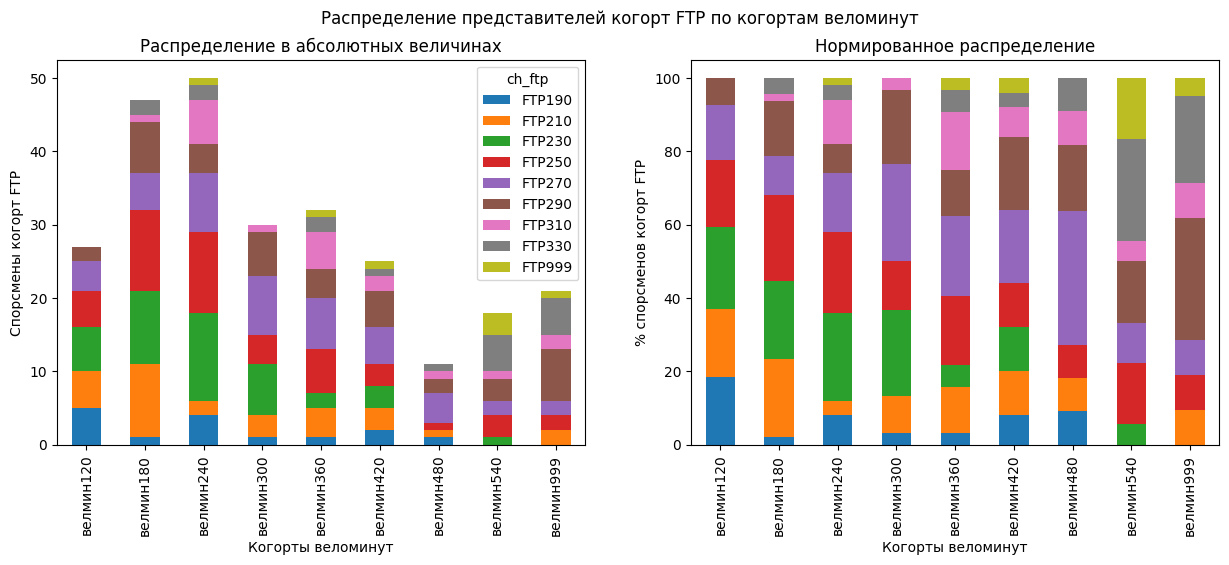

In [293]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

dd = data.groupby(['ch_ftp', 'ch_bm'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_bm', columns = 'ch_ftp', values = 'sport')
dd = dd.fillna(0)

dd.plot.bar(ax = ax[0], stacked = True, figsize=(15,5))

ax[0].set_title('Распределение в абсолютных величинах')
ax[0].set_xlabel('Когорты веломинут')
ax[0].set_ylabel('Спорсмены когорт FTP')

dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.bar(ax = ax[1], stacked = True, figsize=(15,5), legend = None)

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('Когорты веломинут')
ax[1].set_ylabel('% спорсменов когорт FTP')

plt.suptitle('Распределение представителей когорт FTP по когортам веломинут')
plt.show()

**Промежутояные итоги**

Подтверждается взаимосвязь веломинут и FTP. Кроме этого, обнаружилась нелинейная взаимосвязь FTP со стажем, а также выход на "плато" веломинут с ростом стажа.

# Волновой характер роста FTP с ростом веломинут

Когортный анализ показал, что FTP с увеличением веломинут по когортам растет не монотонно! Угадывается некий волновой характер, накладывающийся на линейную зависимость роста веломинут и FTP.

Интерпретироавть эти "волны" можно как неоптимальным объемом тренировок. Завышение веломинут, которое не дает прироста FTP, а скорее наоборот. Спортсменам, попавшим в эти локальные минимумы FTP/веломинуты, можно чуть уменьшить объем, и тогда их FTP вырастет.

## Графики взаимосвязи FTP и веломинут / веломинут и FTP

Аппроксимируем данные многочленами высоких степеней

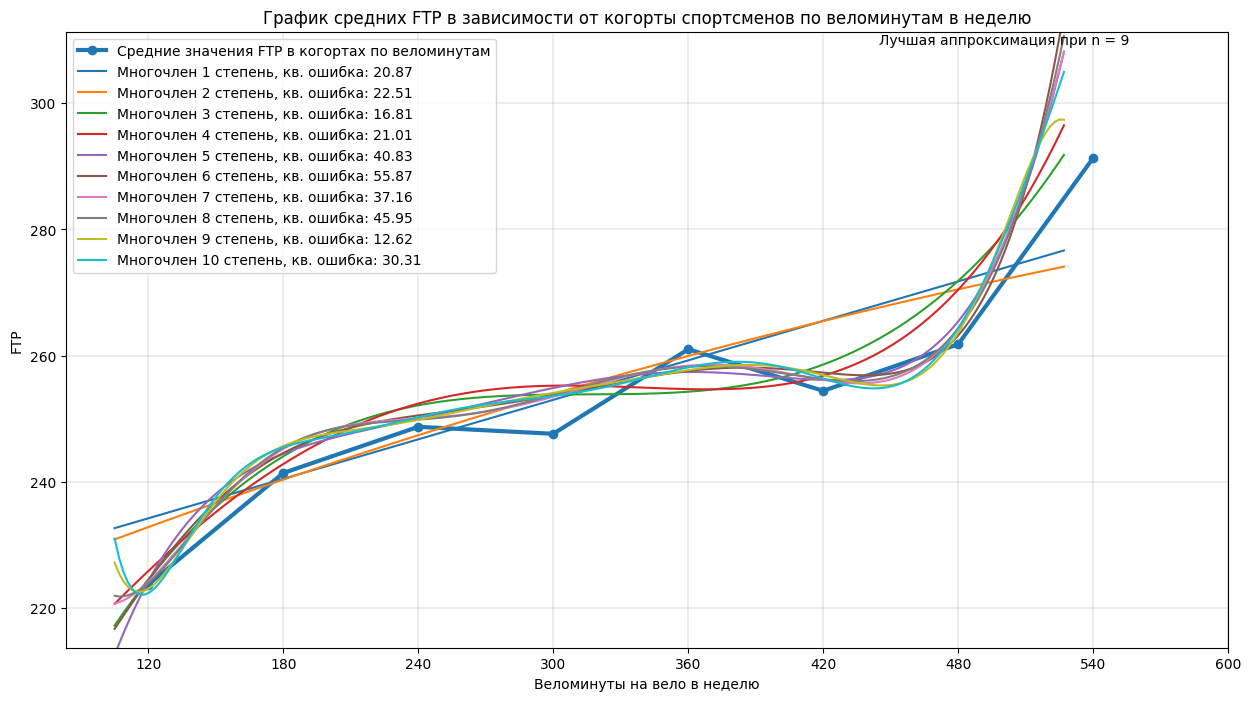

In [294]:
xmin = data['bike_minute'].quantile(0.05)
xmax = data['bike_minute'].quantile(0.90)
sc = data.query('bike_minute > @xmin & bike_minute < @xmax')[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')

fig = plt.figure(figsize = (15, 8))

plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения FTP в когортах по веломинутам')

sslast = 99999999999
for i in range(1, 11):
  z = np.polyfit(sc['bike_minute'], sc['ftp_c'], i)
  p = np.poly1d(z)
  ss = 0
  for x in bikeminut_describe.index[1:-1]:
    ss = ss + (p(x) - bikeminut_describe.loc[x, 'mean']) ** 2
    #print(p(x), bikeminut_describe.loc[x, 'mean'])
  if sslast > ss:
     sslast = ss
     bestn = i
  x = np.arange(xmin, xmax, 2)
  plt.plot(x, p(x), label = f'Многочлен {i} степень, кв. ошибка: {round(math.sqrt(ss), 2)} ')

plt.title('График средних FTP в зависимости от когорты спортсменов по веломинутам в неделю')

plt.annotate(f'Лучшая аппроксимация при n = {bestn}', xy=(0.7, 0.98), xycoords='axes fraction')
plt.xlabel('Веломинуты на вело в неделю')
plt.ylabel('FTP')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(120, 600, 9))
plt.ylim(bikeminut_describe['mean'].min()-10, bikeminut_describe['mean'].max()+20)
#plt.ylim(0, bikeminut_describe['max'].max())
plt.show()

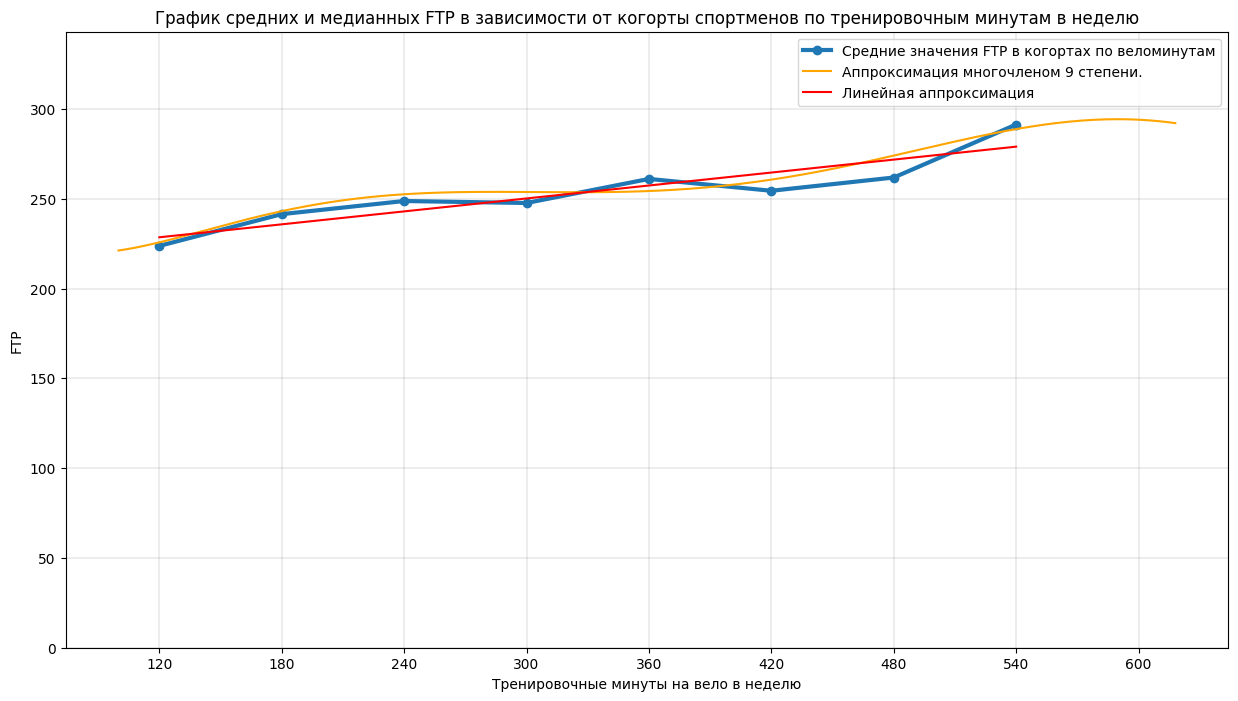

In [295]:
sc = data[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')
xmin = 100
xmax = 620

fig = plt.figure(figsize = (15, 8))
plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения FTP в когортах по веломинутам')

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], bestn)
p = np.poly1d(z)
x = np.arange(xmin, xmax, 2)

plt.plot(x, p(x), color='orange', label = f'Аппроксимация многочленом {bestn} степени.')

z = np.polyfit(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], 1)
p = np.poly1d(z)
plt.plot(bikeminut_describe.index[0:-1], p(bikeminut_describe.index[0:-1]), color='red', label = 'Линейная аппроксимация')

plt.title('График средних и медианных FTP в зависимости от когорты спортменов по тренировочным минутам в неделю')
plt.xlabel('Тренировочные минуты на вело в неделю')
plt.ylabel('FTP')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(120, 600, 9))
plt.ylim(0, bikeminut_describe['max'].max())
plt.show()

Видны просадки FTP у спортсменов из когорт 5 и 7 часов веломинут в неделю.
А может это повышение FTP у тех, кто занимается 6 часов ?

Графики в перевернутых координатах веломинуты от FTP

Аппроксимируем данные многочленами высоких степеней

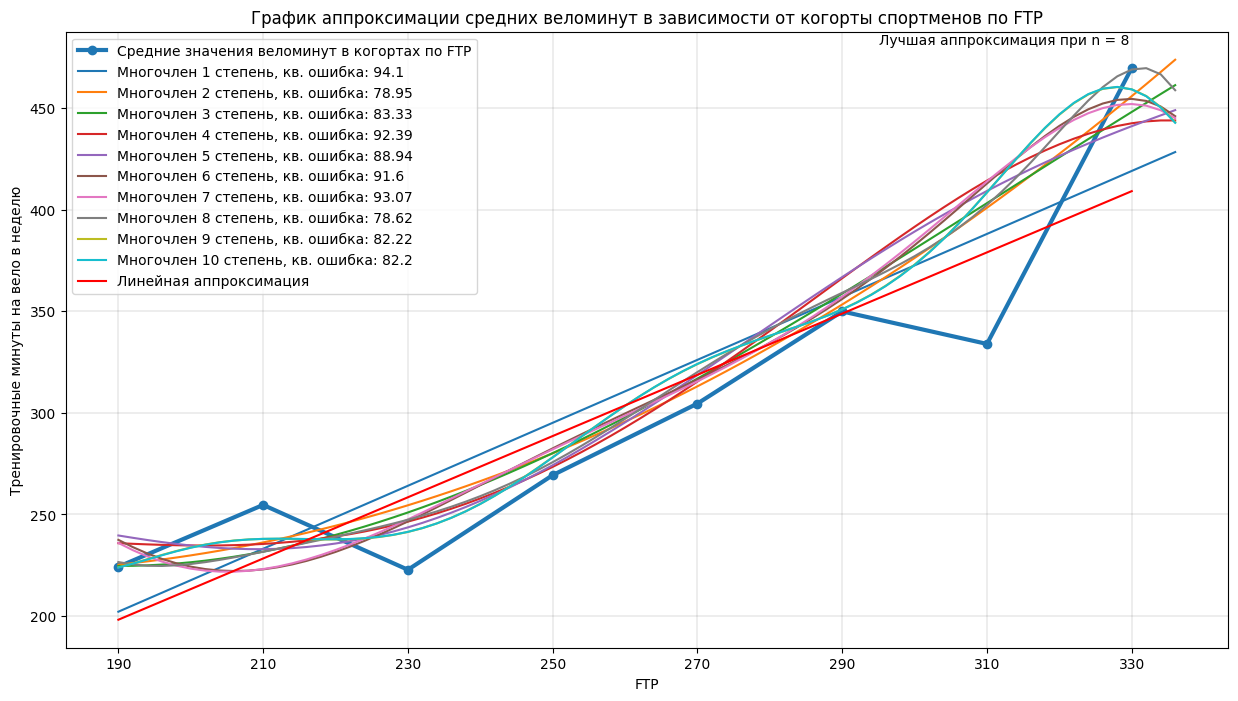

In [296]:
sc = data[['ftp_c', 'bike_minute']].sort_values(by='ftp_c')
xmin = data['ftp_c'].quantile(0.05)
xmax = data['ftp_c'].quantile(0.99)
#xmin = data['ftp_c'].min()
#xmax = data['ftp_c'].max()


fig = plt.figure(figsize = (15, 8))
plt.plot(ftp_describe.index[0:-1], ftp_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения веломинут в когортах по FTP')


sslast = 99999999999
for i in range(1, 11):
  z = np.polyfit(sc['ftp_c'], sc['bike_minute'], i)
  p = np.poly1d(z)
  ss = 0
  for x in ftp_describe.index[1:-1]:
    ss = ss + (p(x) - ftp_describe.loc[x, 'mean']) ** 2
    #print(p(x), ftp_describe.loc[x, 'mean'])
  if sslast > ss:
     sslast = ss
     bestn = i
  x = np.arange(xmin, xmax, 2)
  plt.plot(x, p(x), label = f'Многочлен {i} степень, кв. ошибка: {round(math.sqrt(ss), 2)} ')

z = np.polyfit(ftp_describe.index[0:-1], ftp_describe['mean'][0:-1], 1)
p = np.poly1d(z)
plt.plot(ftp_describe.index[0:-1], p(ftp_describe.index[0:-1]), color='red', label = 'Линейная аппроксимация')

plt.annotate(f'Лучшая аппроксимация при n = {bestn}', xy=(0.7, 0.98), xycoords='axes fraction')
plt.title('График аппроксимации средних веломинут в зависимости от когорты спортменов по FTP')
plt.xlabel('FTP')
plt.ylabel('Тренировочные минуты на вело в неделю')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(190, 330, 8))
#plt.ylim(0, bikeminut_describe['max'].max())
plt.show()

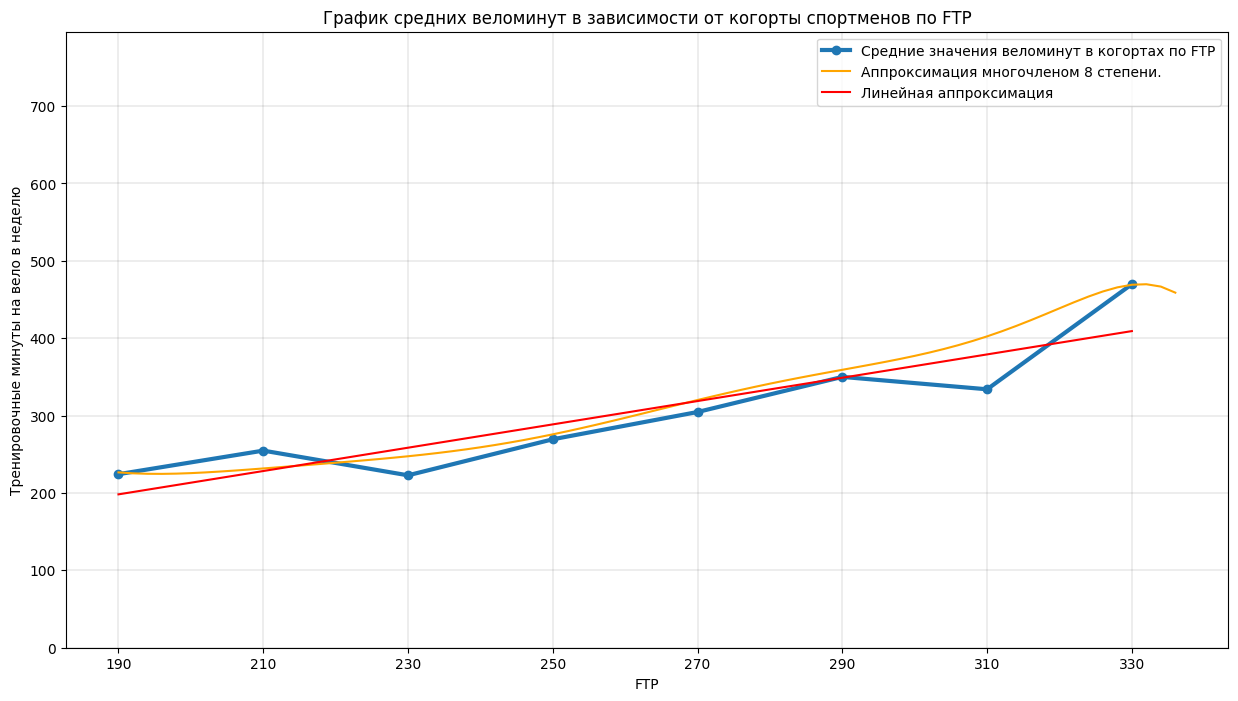

In [297]:
sc = data[['ftp_c', 'bike_minute']].sort_values(by='ftp_c')
xmin = data['ftp_c'].quantile(0.05)
xmax = data['ftp_c'].quantile(0.99)
#xmin = data['ftp_c'].min()
#xmax = data['ftp_c'].max()


fig = plt.figure(figsize = (15, 8))
plt.plot(ftp_describe.index[0:-1], ftp_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения веломинут в когортах по FTP')


z = np.polyfit(sc['ftp_c'], sc['bike_minute'], bestn)
p = np.poly1d(z)
x = np.arange(xmin, xmax, 2)
plt.plot(x, p(x), color='orange', label = f'Аппроксимация многочленом {bestn} степени.')

z = np.polyfit(ftp_describe.index[0:-1], ftp_describe['mean'][0:-1], 1)
p = np.poly1d(z)
plt.plot(ftp_describe.index[0:-1], p(ftp_describe.index[0:-1]), color='red', label = 'Линейная аппроксимация')

plt.title('График средних веломинут в зависимости от когорты спортменов по FTP')
plt.xlabel('FTP')
plt.ylabel('Тренировочные минуты на вело в неделю')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(190, 330, 8))
plt.ylim(0, ftp_describe['max'].max())
plt.show()

В координатах веломинуты от FTP волны заметнее. Все также впорос: это завышение ввеломинут спортсменами из когорт 210 и 290 ватт или более оптимальный объем спорсменов их корот 230 и 310?

## Задача сводится к поиску различий в когортах

Напомним статистические характеристики когорт:

In [298]:
ftp_cohorts_stat

,count_minute,mean_minute,std_minute,min_minute,25%_minute,50%_minute,75%_minute,max_minute,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
190,15.0,224.266667,131.429757,37.0,120.00,195.0,315.00,467.0,15.0,36.333333,22.483857,9.0,21.5,24.0,48.0,84.0
210,30.0,254.700000,161.187436,84.0,131.75,181.0,352.00,726.0,30.0,33.500000,25.510985,2.0,19.5,24.0,45.0,96.0
230,41.0,222.780488,93.434338,60.0,165.00,215.0,270.00,483.0,41.0,48.487805,36.928391,7.0,24.0,36.0,60.0,156.0
250,46.0,269.347826,148.417612,30.0,168.00,231.5,330.75,780.0,46.0,42.717391,26.380686,6.0,24.0,36.0,60.0,120.0
270,45.0,304.600000,144.160643,25.0,200.00,286.0,380.00,687.0,45.0,50.022222,30.171095,9.0,24.0,48.0,60.0,144.0
290,40.0,349.955000,176.043669,35.0,214.00,336.0,483.75,724.0,40.0,52.350000,36.119140,2.0,24.0,42.0,63.0,156.0
310,19.0,333.947368,133.918911,150.0,219.50,316.0,410.00,635.0,19.0,49.263158,24.460494,18.0,36.0,48.0,57.0,120.0
330,18.0,469.777778,187.845542,172.0,344.25,514.0,555.00,796.0,18.0,59.222222,32.184314,10.0,39.0,54.0,72.0,144.0
999,7.0,459.000000,148.573214,235.0,366.50,510.0,525.50,684.0,7.0,49.714286,20.113961,24.0,36.0,48.0,60.0,84.0


In [299]:
bikeminute_cohorts_stat

,count_ftp,mean_ftp,std_ftp,min_ftp,25%_ftp,50%_ftp,75%_ftp,max_ftp,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
120,27.0,223.740741,35.228477,139.0,200.50,220.0,247.50,290.0,27.0,37.518519,39.466023,2.0,15.5,24.0,39.0,156.0
180,47.0,241.425532,34.823621,187.0,214.00,240.0,262.50,330.0,47.0,43.914894,27.950134,12.0,24.0,36.0,60.0,120.0
240,50.0,248.740000,38.149443,180.0,222.75,240.0,272.50,335.0,50.0,43.180000,26.637161,7.0,24.0,36.0,52.5,144.0
300,30.0,247.633333,29.643262,190.0,230.00,251.0,270.75,302.0,30.0,46.566667,30.449147,10.0,24.0,42.0,60.0,120.0
360,32.0,261.031250,41.546309,160.0,238.25,265.0,291.25,343.0,32.0,46.687500,22.835227,12.0,24.0,48.0,60.0,84.0
420,25.0,254.440000,43.333090,163.0,230.00,264.0,280.00,335.0,25.0,55.080000,35.482296,6.0,24.0,48.0,60.0,144.0
480,11.0,261.818182,41.542311,179.0,247.50,268.0,283.50,325.0,11.0,57.363636,45.546180,12.0,21.0,48.0,84.0,144.0
540,18.0,291.333333,37.671959,225.0,255.25,298.5,320.00,340.0,18.0,53.722222,24.028918,9.0,36.0,45.0,72.0,96.0
999,21.0,283.142857,36.827009,199.0,270.00,286.0,312.00,335.0,21.0,52.190476,34.075826,10.0,36.0,48.0,60.0,144.0


## Гипотезы

**Гипотеза: эффект связан с тренировочным стажем**. То есть в когортах ftp210 и ftp290 менее опытные спортсмены, которые и завышают свои веломинуты.


Тепловая карта FTP / стажа

In [300]:
dd = data.groupby(['ch_ftp', 'ch_st'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_st', columns = 'ch_ftp', values = 'sport')
dd = dd.fillna(0)[::-1]
dd.style.background_gradient(cmap ='RdYlGn_r').format(precision=0)

ch_ftp,FTP190,FTP210,FTP230,FTP250,FTP270,FTP290,FTP310,FTP330,FTP999
ch_st,,,,,,,,,
стаж999,0,2,5,2,4,6,1,3,0
стаж90,1,1,4,5,1,1,1,1,1
стаж78,1,1,1,1,5,3,1,2,0
стаж66,1,1,5,6,9,3,2,3,2
стаж54,3,3,0,4,7,7,6,4,1
стаж42,0,2,9,9,5,9,4,3,2
стаж30,5,12,9,11,5,8,3,0,1
стаж18,4,8,8,8,9,3,1,2,0


Распредделение

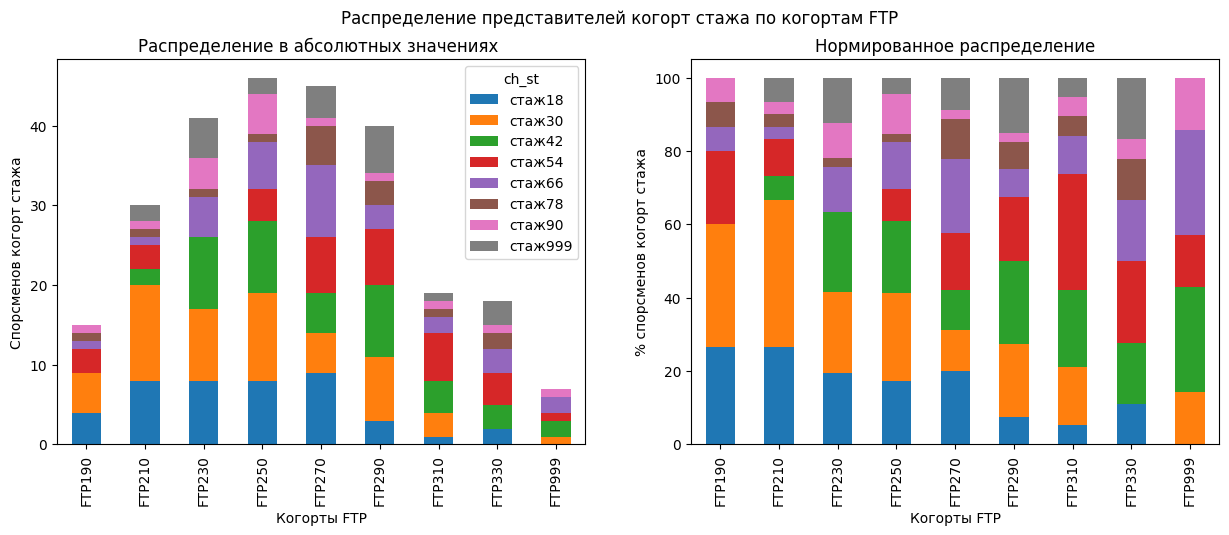

In [301]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

dd = data.groupby(['ch_ftp', 'ch_st'])['sport'].count()
dd = dd.reset_index()
dd = dd.pivot_table(index = 'ch_ftp', columns = 'ch_st', values = 'sport')
dd = dd.fillna(0)

dd.plot.bar(ax = ax[0], stacked = True, figsize=(15,5))

ax[0].set_title('Распределение в абсолютных значениях ')
ax[0].set_xlabel('Когорты FTP')
ax[0].set_ylabel('Спорсменов когорт стажа')

dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.bar(ax = ax[1], stacked = True, figsize=(15,5), legend = None)

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('Когорты FTP')
ax[1].set_ylabel('% спорсменов когорт стажа')


plt.suptitle('Распределение представителей когорт стажа по когортам FTP')
plt.show()

На графиках более высокие секции - более опытные спорстмены. Соответственно, если в когорте более высокие секции "шире в высоту", то это осначает, что там больше опытных спорсменов. И на оборот, если более широкие нижние секции - в этой когорте больше малоопытных спортсменов.

Для когорты ftp210 "на глаз" это выполняется. Для когорты ftp290 - не так очевидно.

Сравним попарно стаж в когортах статистическими тестами

Проверка на нормальное распределение. В ячейцках значения p-value для распределени способа определения FTP. Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения НЕ пройдена.


In [302]:
#ftp_box_norm = pd.DataFrame([])
#for ff1 in ftpbox:
#    pval = stats.normaltest(ftpbox[ff1]['stag_r'])[1]
#    ftp_box_norm.loc['norm', ff1] = pval
#ftp_box_norm.style.apply(highlight_stat, color='tomato')

Проверка на равенства дисперсий. В ячейцках значения p-value для попарного сравнения дисперсий выборок. Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий НЕ пройдена.

In [303]:
ftp_box_leneve = pd.DataFrame([])
for ff1 in ftpbox:
  for ff2 in ftpbox:

        pval = stats.levene(ftpbox[ff1]['stag_r'], ftpbox[ff2]['stag_r'])[1]

        ftp_box_leneve.loc[ff1, ff2] = pval
ftp_box_leneve.style.apply(highlight_stat, color='tomato')

,190,210,230,250,270,290,310,330,999
190,1.000000,0.891305,0.251720,0.583859,0.344060,0.277373,0.893654,0.396484,0.813904
210,0.891305,1.000000,0.108351,0.399796,0.186962,0.128342,0.992720,0.280645,0.912673
230,0.251720,0.108351,1.000000,0.222168,0.485299,0.898765,0.163582,0.692569,0.320527
250,0.583859,0.399796,0.222168,1.000000,0.521104,0.273990,0.437520,0.549517,0.497156
270,0.344060,0.186962,0.485299,0.521104,1.000000,0.574915,0.227898,0.906571,0.340605
290,0.277373,0.128342,0.898765,0.273990,0.574915,1.000000,0.183665,0.763696,0.336109
310,0.893654,0.992720,0.163582,0.437520,0.227898,0.183665,1.000000,0.290996,0.892300
330,0.396484,0.280645,0.692569,0.549517,0.906571,0.763696,0.290996,1.000000,0.372095
999,0.813904,0.912673,0.320527,0.497156,0.340605,0.336109,0.892300,0.372095,1.000000


Используется тест Мана-Утни, так как выборки получаются небольшие и не проходят проверку на нормальное распределение.

В ячейках - p-value нулевой гипозеты H0, что стаж спортменов из когорты FTP по вертикали такой же как из когорты по горизонтали, альтернативная гипотеза H1 - что стаж МЕНЬШЕ.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

In [304]:
ftp_box_pval = pd.DataFrame([])
for ff1 in ftpbox:
  for ff2 in ftpbox:
    #ftp_box_pval.loc[ff1, ff2] = stats.ttest_ind(ftpbox[ff1]['stag_r'], ftpbox[ff2]['stag_r'], alternative = 'less', equal_var='True')[1]
    ftp_box_pval.loc[ff1, ff2] = stats.mannwhitneyu(ftpbox[ff1]['stag_r'], ftpbox[ff2]['stag_r'], alternative = 'less')[1]
ftp_box_pval.style.apply(highlight_stat, color='lime')

,190,210,230,250,270,290,310,330,999
190,0.508392,0.727280,0.169331,0.208638,0.064077,0.057905,0.049569,0.015123,0.067381
210,0.280981,0.503055,0.030156,0.036282,0.005759,0.003616,0.004121,0.001588,0.019418
230,0.835317,0.970637,0.501859,0.599655,0.255883,0.188361,0.175103,0.049087,0.209419
250,0.796180,0.964568,0.403655,0.501572,0.137599,0.134665,0.116441,0.020810,0.156655
270,0.938050,0.994418,0.746905,0.864152,0.501623,0.515916,0.494091,0.144996,0.393365
290,0.944270,0.996512,0.814194,0.867218,0.487620,0.501940,0.383946,0.109332,0.352801
310,0.953922,0.996126,0.828984,0.886384,0.511816,0.622301,0.505905,0.131084,0.396052
330,0.986212,0.998520,0.952571,0.979932,0.858471,0.893811,0.875340,0.506384,0.768902
999,0.941420,0.982383,0.798939,0.849628,0.617002,0.658360,0.626332,0.250167,0.526138


В результате сравнения выборок: у спортсменов из когорты FTP 210 ватт в сравнении с спортсменами из когорт 230-999 нулевая гипотеза отвергается в пользу альтернативной.
То есть у спортсменов из когорты 210 ватт статистически достоверно меньше стажа, чем в когорте 230. Для спортсменов из когорты FTP 310 ватт меньший стаж относительно соседних когорт - не подтверждается.

**Гипотеза, что "ямы" близки к "круглым" значениям**:  300, 420 минут - это 5 и 7 часов соответственно. Возможно, спортсмены "добивают" объем до круглого числа бесполезными тренировками, которые не приносят результата.

In [305]:
minute_pit = data.query('230 <= bike_minute <= 250 | 410 <= bike_minute <= 430')['ftp_c']
minute_not_pit = data.query('~(230 <= bike_minute <= 250 | 410 <= bike_minute <= 430)')['ftp_c']

In [306]:
print(f'Среднее FTP у спорстменов около 300 и 420 веломинут - {round(minute_pit.mean(),2)}')
print(f'Среднее FTP у спорстменов далеких от 300 и 420 веломинут - {round(minute_not_pit.mean(), 2)}')

Среднее FTP у спорстменов около 300 и 420 веломинут - 251.61
Среднее FTP у спорстменов далеких от 300 и 420 веломинут - 253.22


In [307]:
test_selection(minute_pit,
               minute_not_pit,
               side='less',
               h0 = 'у спорстменом, с объемом веломинут около 300 и 420, FTP как и у остальных',
               h1 = 'У спорстменов, с объемом веломинут около 300 и 420, FTP меньше',
               )

Первая выборка размером 33 прошла проверку на нормальное распределение. pval = 0.7465290903957978
Вторая выборка размером 228 прошла проверку на нормальное распределение. pval = 0.10783448162080263
Дисперсии выборок близки. pval = 0.7795033412184833. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.4158347966844111
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  у спорстменом, с объемом веломинут около 300 и 420, FTP как и у остальных 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.3741732856073868
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  у спорстменом, с объемом веломинут около 300 и 420, FTP как и у остальных 


Убедительно статистическими тестами подвердить эту гипотезу также не удалось. Хотя, если подкрутить интервалы - нужные результаты тестов получаются....

Наконец, есть **гипотеза, что это просто методическая погрешность**, связанная с тем, что в опросе частью спорстменов указываются целое количество часов "на глаз и примерно". Другие же указали данные из какого-либо сервиса анализа своих тренировок с точностью до секунд.

# Сравнение тренировок у велосипедистов и триатлетов

Разделим спортсменов на велосипедистов - те у кого только велотренировки, и условных триатлетов - те у кого кроме вело, есть и тренировки по другим видам спорта

In [308]:
velo_only = data[data['train_minute'] < 10].copy()
velo_plus = data[data['train_minute'] > 0].copy()
velo_plus['all_minute'] = velo_plus['bike_minute'] + velo_plus['train_minute']

Проверка на аномалии

In [309]:
velo_plus.query('all_minute > 1200')

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,stag_r,bike_minute,train_minute,weigth_c,ftp_c,ftp_weigth,ftp_source_c,ch_ftp,ch_bm,ch_st,all_minute
148,2024-12-28 23:42:25.926,71.0,Мужской,Триатлон,08:41:31,12:00:00,"5 лет, 1.5 года структурированных тренировок с переодизацией",290,По результатом полевых тестирований,60,521.0,720.0,71.0,290.0,4.084507,По результатом полевых тестирований,FTP290,велмин540,стаж66,1241.0


Диаграммы рассеяния FTP и веломинут у велосипедистов, а у триатлетов веломинут и длительность обычных тренировок

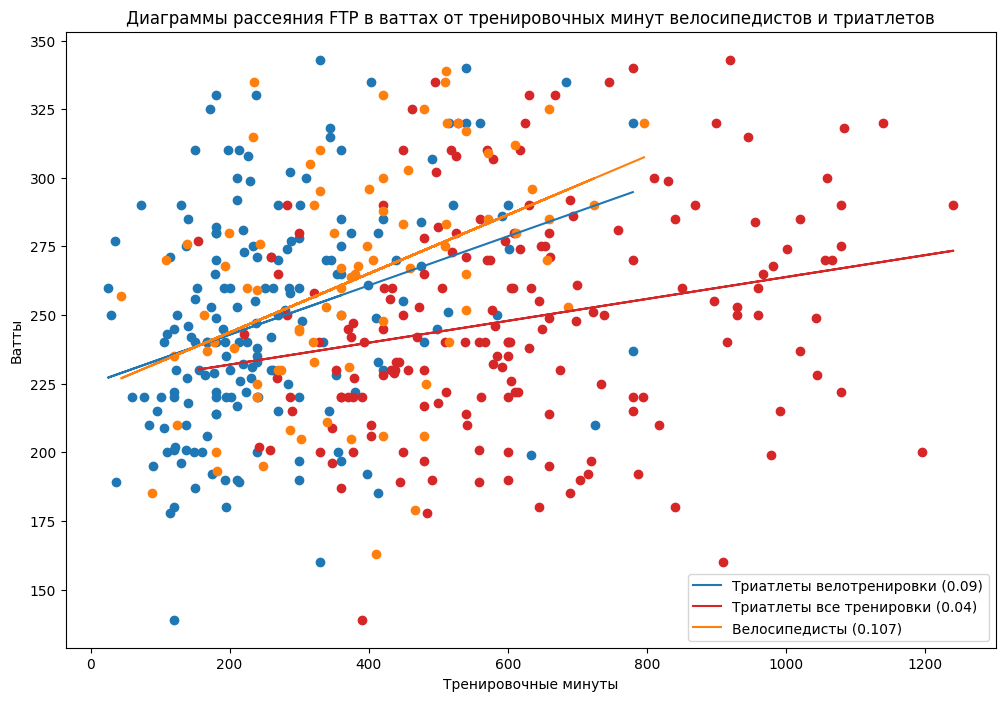

In [310]:
plt.figure(figsize=(12,8))
plt.scatter(velo_plus['bike_minute'], velo_plus['ftp_c'], color='tab:blue')
z = np.polyfit(velo_plus['bike_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'Триатлеты велотренировки ({round(z[0], 3)})'
plt.plot(velo_plus['bike_minute'], p(velo_plus['bike_minute']), color='tab:blue', label = l)

plt.scatter(velo_plus['all_minute'], velo_plus['ftp_c'], color='tab:red')
z = np.polyfit(velo_plus['all_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'Триатлеты все тренировки ({round(z[0], 3)})'
plt.plot(velo_plus['all_minute'], p(velo_plus['all_minute']), color='tab:red', label = l)


plt.scatter(velo_only['bike_minute'], velo_only['ftp_c'], color='tab:orange')
z = np.polyfit(velo_only['bike_minute'], velo_only['ftp_c'], 1)
p = np.poly1d(z)
l = f'Велосипедисты ({round(z[0], 3)})'
plt.plot(velo_only['bike_minute'], p(velo_only['bike_minute']), color='tab:orange', label = l)

plt.title('Диаграммы рассеяния FTP в ваттах от тренировочных минут велосипедистов и триатлетов')
plt.ylabel('Ватты')
plt.xlabel('Тренировочные минуты')
plt.legend()
plt.show()

Статистические характеристики велосипедистов

In [311]:
velo_only[['ftp_c', 'bike_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,82.0,262.780488,41.047105,163.0,235.5,266.0,290.00,339.0
Веломинуты,82.0,378.746341,162.636145,44.0,245.0,373.5,503.25,796.0


Статистические характеристики триатлетов

In [312]:
velo_plus[['ftp_c', 'bike_minute', 'all_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты', 'all_minute' : 'Все тренировки'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,179.0,248.547486,39.926080,139.0,220.0,245.0,275.0,343.0
Веломинуты,179.0,263.636872,147.641712,25.0,166.0,226.0,343.5,780.0
Все тренировки,179.0,616.826816,228.993715,155.0,447.0,592.0,742.0,1241.0


Доля велотренировок у триатетов

In [313]:
velo_plus['train_prob'] = round(100 * velo_plus['bike_minute'] / velo_plus['all_minute'], 2)
print(f"Средняя доля велотренировок у триатлетов - {round(velo_plus['train_prob'].mean(), 2)}%")

Средняя доля велотренировок у триатлетов - 43.46%


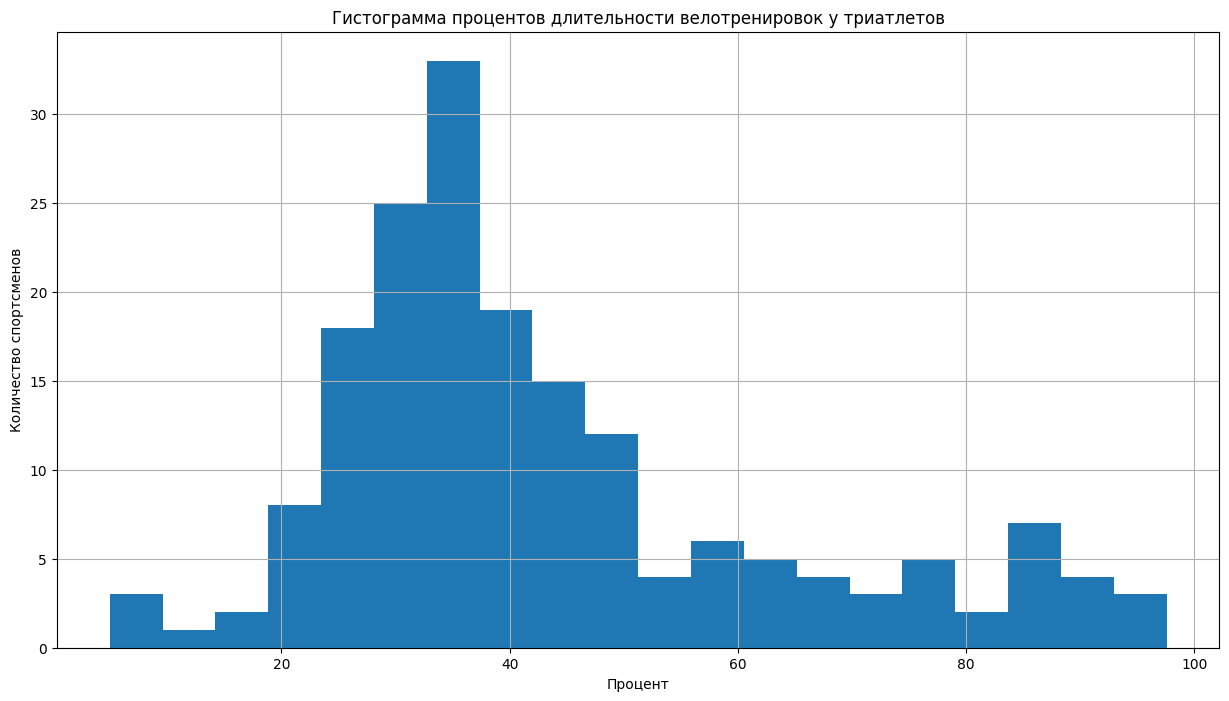

In [314]:
plt.figure(figsize=(15,8))

velo_plus['train_prob'].hist(bins = 20, alpha = 1, color = 'tab:blue', label = 'Триатлеты')
plt.title('Гистограмма процентов длительности велотренировок у триатлетов')
plt.ylabel('Количество спортсменов')
plt.xlabel('Процент')
#plt.legend()
plt.show()

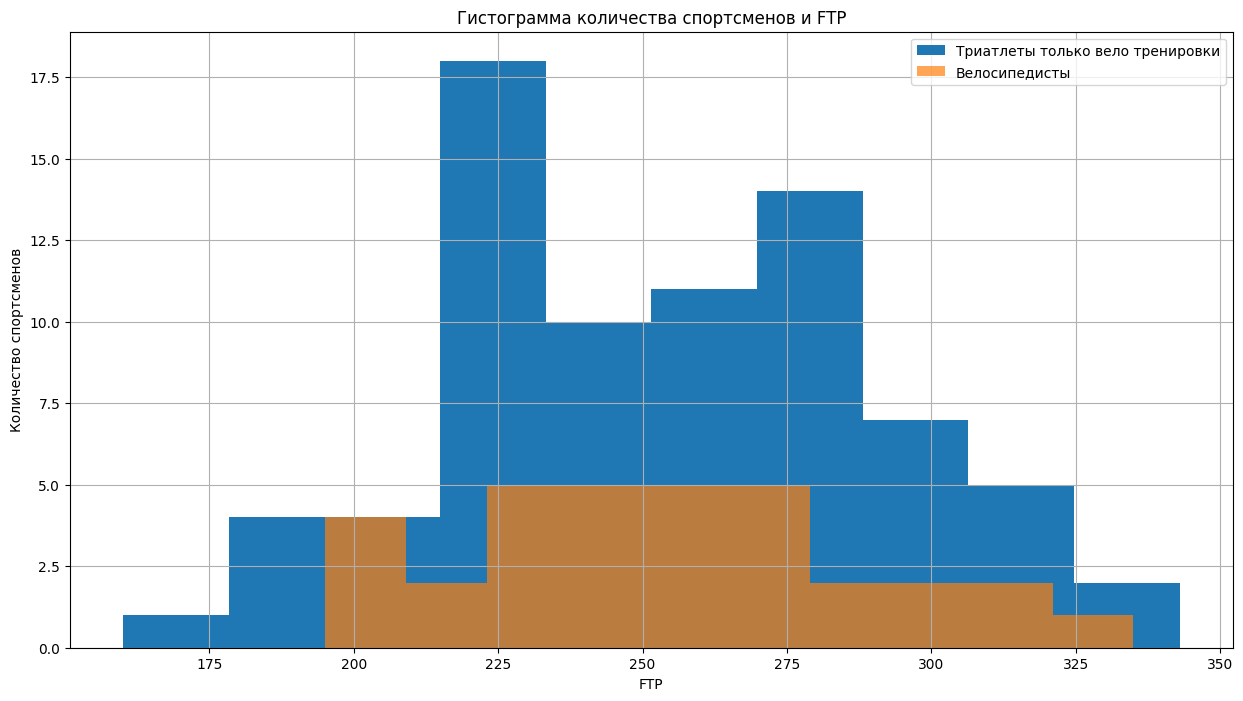

In [315]:
plt.figure(figsize=(15,8))

velo_plus.query('bike_minute > 200 & bike_minute < 400')['ftp_c'].hist(bins = 10, alpha = 1, color = 'tab:blue', label = 'Триатлеты только вело тренировки')
velo_only.query('bike_minute > 200 & bike_minute < 400')['ftp_c'].hist(bins = 10, alpha = 0.7,  color = 'tab:orange', label = 'Велосипедисты')
plt.title('Гистограмма количества спортсменов и FTP')
plt.ylabel('Количество спортсменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

Проверим гипотезу, что при сопоставимом объеме только велотренировок у велоиспедистов и триатлетов, у первых будет выше FTP.

Вторая гипотеза: при сопоставимом FTP у велосипедистов и триатлетов у первых будет больше только велотренировок.

Третья гипотеза: при сопоставимом FTP у велосипедистов и триатлетов у последних общий объем всех тренировок будет больше, чем веломинут у велосипедистов

Проверку гипотез проведем только на спортсменах из середенной половины. Для этого возьмем границы из "золотой середины" статистических характетистик FTP и длительности тренировок

In [316]:
ftp_gold_min = train_stat.loc['FTP', '25%']
ftp_gold_max = train_stat.loc['FTP', '75%']
bikeminute_gold_min = train_stat.loc['Вело тренировки', '25%']
bikeminute_gold_max = train_stat.loc['Вело тренировки', '75%']
allminute_gold_min = velo_plus['all_minute'].describe().loc['25%']
allminute_gold_max = velo_plus['all_minute'].describe().loc['75%']

In [317]:
print(f"Границы серединной половины по FTP {ftp_gold_min} - {ftp_gold_max}")
print(f"Границы серединной половины по веломинутам {bikeminute_gold_min} - {bikeminute_gold_max}")
print(f"Границы серединной половины по минутам всех тренировок {allminute_gold_min} - {allminute_gold_max}")

Границы серединной половины по FTP 225.5 - 290.0
Границы серединной половины по веломинутам 180.0 - 420.0
Границы серединной половины по минутам всех тренировок 447.0 - 742.0


In [318]:
velo_compare = pd.DataFrame(columns = ('FTP', 'train_duration'))
velo_compare.loc['велосипедисты','FTP'] = round(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['триатлеты только вело','FTP'] = round(velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['триатлеты все тренировки','FTP'] = round(velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].mean(), 2)


In [319]:
print(f"Средний FTP велосипедистов из золотой середины по длительности велотренировок - {velo_compare.loc['велосипедисты', 'FTP']} ватт")
print(f"Средний FTP триатлетов из золотой середины по длительности велотренировок - {velo_compare.loc['триатлеты только вело', 'FTP']} ватт")
print(f"Средний FTP триатлетов из золотой середины по длительности всех тренировок - {velo_compare.loc['триатлеты все тренировки', 'FTP']} ватт")

Средний FTP велосипедистов из золотой середины по длительности велотренировок - 252.74 ватт
Средний FTP триатлетов из золотой середины по длительности велотренировок - 250.95 ватт
Средний FTP триатлетов из золотой середины по длительности всех тренировок - 250.43 ватт


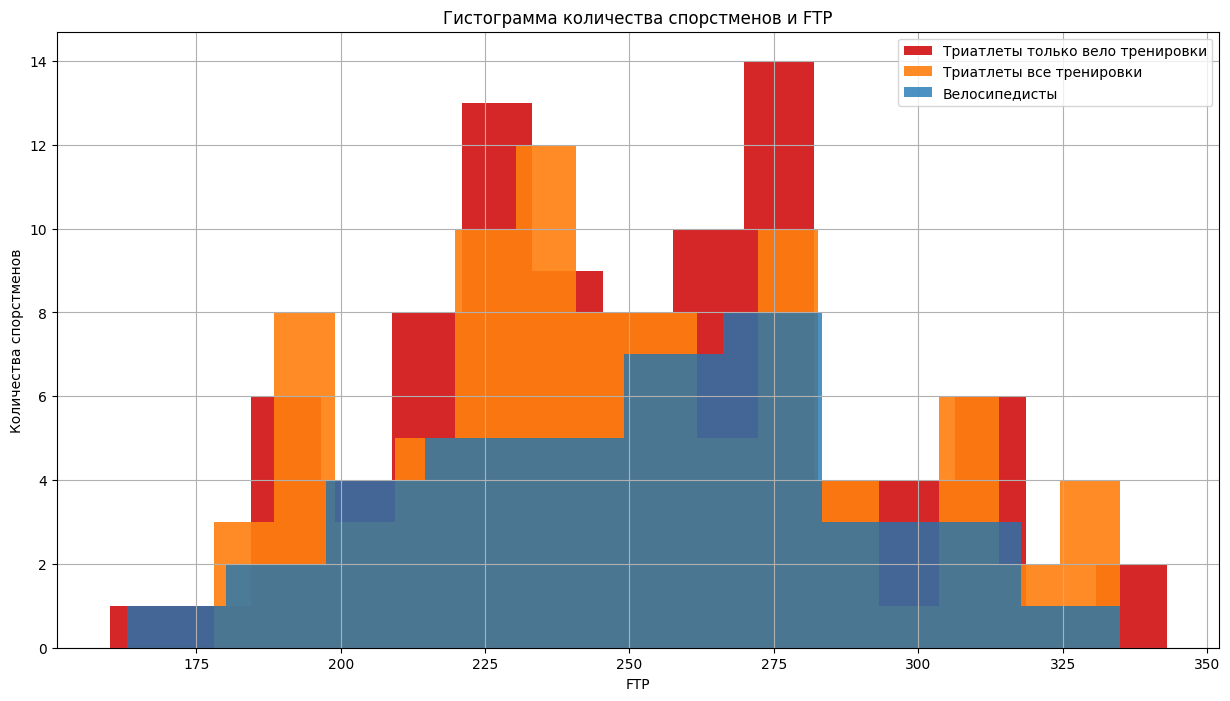

In [320]:
plt.figure(figsize=(15,8))


velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 1, color = 'tab:red', label = 'Триатлеты только вело тренировки')
velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 0.9,  color = 'tab:orange', label = 'Триатлеты все тренировки')
velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 10, alpha = 0.8, color = 'tab:blue', label = 'Велосипедисты')
plt.title('Гистограмма количества спорстменов и FTP')
plt.ylabel('Количества спорстменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

In [321]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по веломинутам, имеют одинаковые FTP',
               h1 = 'У велосипедистов, из "золотой середины" по веломинутам, FTP больше',
               )

Первая выборка размером 39 прошла проверку на нормальное распределение. pval = 0.959294937008149
Вторая выборка размером 91 прошла проверку на нормальное распределение. pval = 0.7370206374663524
Дисперсии выборок близки. pval = 0.7821385718715953. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.40276690306187457
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по веломинутам, имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.3610166711356035
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по веломинутам, имеют одинаковые FTP 


In [322]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по всем тренировкам, имеют одинаковые FTP',
               h1 = 'У велосипедистов, из "золотой середины" по всем тренировкам, FTP больше',
               )

Первая выборка размером 39 прошла проверку на нормальное распределение. pval = 0.959294937008149
Вторая выборка размером 89 прошла проверку на нормальное распределение. pval = 0.16795397838405918
Дисперсии выборок близки. pval = 0.5826130069741611. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.3787205577330226
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по всем тренировкам, имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.3317827255344259
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по всем тренировкам, имеют одинаковые FTP 


То есть велосипедисты и триатлеты по показателю FTP как часовой максимальной мощности - сопоставимы / равны / одинаковы

In [323]:
velo_compare.loc['велосипедисты','train_duration'] = round(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['триатлеты только вело','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['триатлеты все тренировки','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].mean(), 2)

In [324]:
print(f"Средняя длительность велотренировок велосипедистов из золотой середины FTP - {velo_compare.loc['велосипедисты','train_duration']} минут")
print(f"Средняя длительность велотренировок триатлетов из золотой середины FTP - {velo_compare.loc['триатлеты только вело','train_duration']} минут")
print(f"Средняя длительность всех тренировок триатлетов из золотой середины FTP - {velo_compare.loc['триатлеты все тренировки','train_duration']} минут")

Средняя длительность велотренировок велосипедистов из золотой середины FTP - 362.9 минут
Средняя длительность велотренировок триатлетов из золотой середины FTP - 269.82 минут
Средняя длительность всех тренировок триатлетов из золотой середины FTP - 617.16 минут


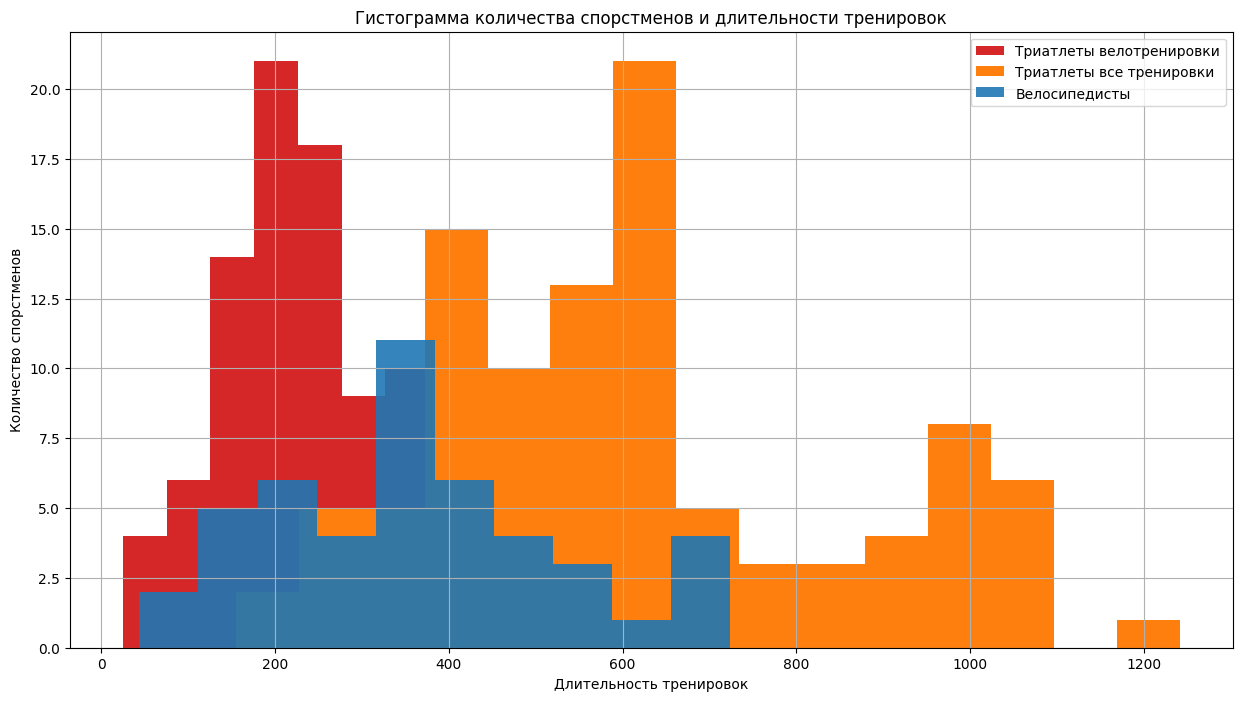

In [325]:
plt.figure(figsize=(15,8))


velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 15, alpha = 1, color = 'tab:red', label = 'Триатлеты велотренировки')
velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].hist(bins = 15, alpha = 1,  color = 'tab:orange', label = 'Триатлеты все тренировки')
velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 10, alpha = 0.9, color = 'tab:blue', label = 'Велосипедисты')
plt.title('Гистограмма количества спорстменов и длительности тренировок')
plt.ylabel('Количество спорстменов')
plt.xlabel('Длительность тренировок')
plt.legend()
plt.show()

In [326]:
test_selection(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по FTP имеют, одинаковое количество веломинут',
               h1 = 'У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у триатлетов',
               )

Первая выборка размером 46 прошла проверку на нормальное распределение. pval = 0.5345092708113571
Вторая выборка размером 101 НЕ прошла проверку на нормальное распределение. pval = 9.528968879609647e-05
Дисперсии выборок близки. pval = 0.1514764648985762. Применяем equal_var=True 

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.000259446404365038
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у триатлетов 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.0003461213408341833
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у триатлетов 


In [327]:
test_selection(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'],
               velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по FTP, имеют одинаковую суммарную длительность всех тренировок',
               h1 = 'У триатлетов, из "золотой середины" по FTP, длительность всех тренировок больше',
               )

Первая выборка размером 101 прошла проверку на нормальное распределение. pval = 0.06378489255090247
Вторая выборка размером 46 прошла проверку на нормальное распределение. pval = 0.5345092708113571
Дисперсии выборок НЕ близки. pval = 0.036106365824968456. Применяем equal_var=False

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 4.600074510294577e-12
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У триатлетов, из "золотой середины" по FTP, длительность всех тренировок больше 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 7.17883788733306e-10
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У триатлетов, из "золотой середины" по FTP, длительность всех тренировок больше 


То есть у велосипедистов больше именно велотренировок, чем у триатлетов, но у триатлетов больше вообще тренировок, чем у велосипедистов. При этом FTP сопоставимы.


In [328]:
velo_compare.T

,велосипедисты,триатлеты только вело,триатлеты все тренировки
FTP,252.74,250.95,250.43
train_duration,362.9,269.82,617.16


In [329]:
print(f"У велосипедистов велотренировок больше, чем у триатлетов на {round(100 * (velo_compare.loc['велосипедисты', 'train_duration'] - velo_compare.loc['триатлеты только вело', 'train_duration']) / velo_compare.loc['триатлеты только вело', 'train_duration'], 2) } %")
print(f"У триатлетов всех тренировок больше, чем велотренировок у велосипедистов на {round(100 * (velo_compare.loc['триатлеты все тренировки', 'train_duration'] - velo_compare.loc['велосипедисты', 'train_duration']) / velo_compare.loc['велосипедисты', 'train_duration'], 2) } %")
print(f"При этому у велосипедистов FTP больше, чем у триатлетов на {round(100 * (velo_compare.loc['велосипедисты', 'FTP'] - velo_compare.loc['триатлеты все тренировки', 'FTP']) / velo_compare.loc['триатлеты все тренировки', 'FTP'], 2) } %")

У велосипедистов велотренировок больше, чем у триатлетов на 34.5 %
У триатлетов всех тренировок больше, чем велотренировок у велосипедистов на 70.06 %
При этому у велосипедистов FTP больше, чем у триатлетов на 0.92 %


**Промежуточные итоги**

Триатлеты с меньшим количеством веломинут не уступают велосипедистам по показателям FTP. Получается, обнаруженная взаимосвязь FTP и веломинут ломается. Однако у триатлетов есть и другие тренировки. И тут встает вопрос: это триатлеты более эффективно тренируются именно на вело, или они добирают в других видах тренировок?

# Сравнение способов определения FTP

FTP - это функциональная пороговая мощность или максимальная мощность, которую спортсмен способен проявить при езде на велосипеде в течение 60 минут. Это базовый показатель, на основе которого строятся тренировочные планы. Фактически он задает интенсивность тренровок, поэтму очень важно точно определить свое текущее FTP.

При этом существует несколько способов опредеения FTP. Само по себе такое разнообразие подразумевает определенные недостатки в каждом из них.

Поэтому стоит понимать, что в тренировочном процессе завышение FTP значительно хуже занижения. Так как занижениие грозит только тем, что спорстмен не достигнет уровня, который мог бы. А завышение FTP грозит уже непомерной наргузкой, перетренированностью и срывом выполнения всего тренировочного плана.

In [330]:
data['ftp_source_c'] = data['ftp_source'].apply(lambda x: 'Другое' if x not in (
    'По результатом полевых тестирований',
    'Из своих результатах на тренировках',
    'Расчетным путем исходя их результатов гонок',
    'Из результатов лабораторного тестирования',
    ) else x)

In [331]:
data['ftp_source_c'] = data['ftp_source_c'].str.replace('По результатом полевых тестирований', 'Поле')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Из своих результатах на тренировках', 'Тренировки')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Расчетным путем исходя их результатов гонок', 'Гонки')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Из результатов лабораторного тестирования', 'Лаборатория')

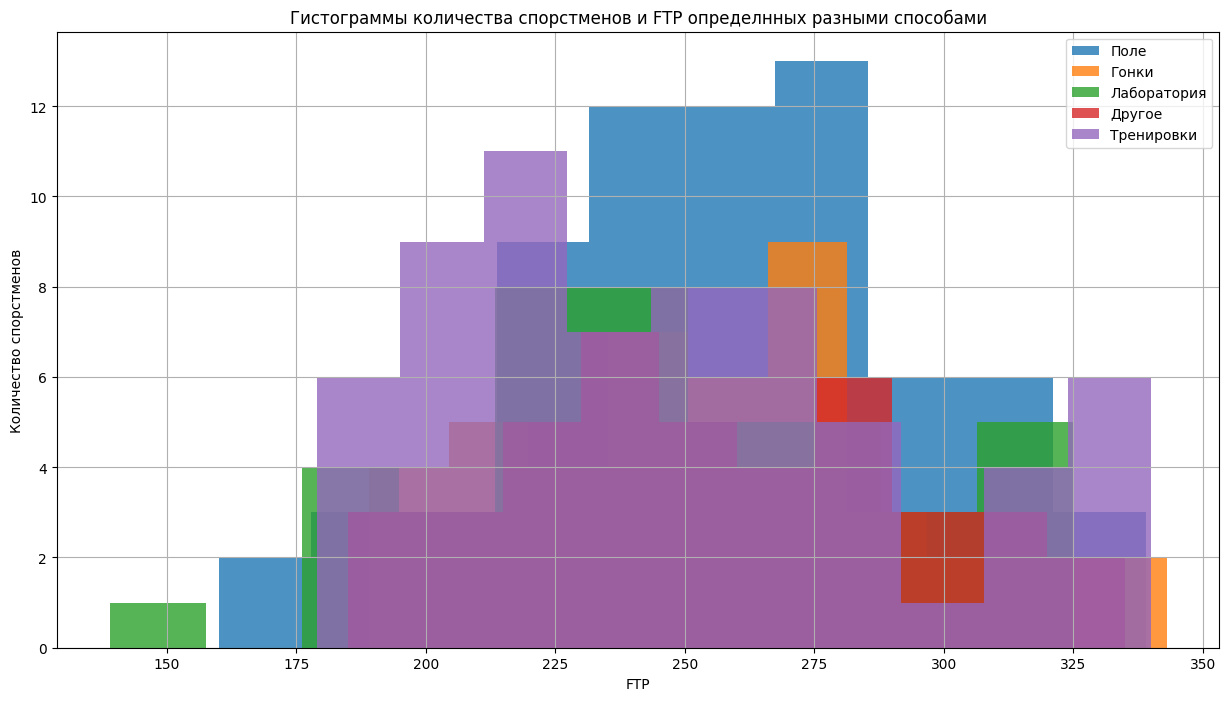

In [332]:
plt.figure(figsize=(15,8))

for ftp_souce in data['ftp_source_c'].unique():
  data.query('ftp_source_c == @ftp_souce')['ftp_c'].hist(bins = 10, alpha = 0.8, label = ftp_souce)

plt.title('Гистограммы количества спорстменов и FTP определнных разными способами')
plt.ylabel('Количество спорстменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

In [333]:
ftp_souce_type = data['ftp_source_c'].unique()
ftp_sourcep_data = dict()
for ftp_source_x in ftp_souce_type:
    ftp_sourcep_data[ftp_source_x] = data.query('ftp_source_c == @ftp_source_x')['ftp_c']
    print(f"{len(ftp_sourcep_data[ftp_source_x])} спорстменов определили свой FTP {ftp_source_x}. Среднее значсение FTP {ftp_sourcep_data[ftp_source_x].median()}")

69 спорстменов определили свой FTP Поле. Среднее значсение FTP 260.0
44 спорстменов определили свой FTP Гонки. Среднее значсение FTP 260.0
42 спорстменов определили свой FTP Лаборатория. Среднее значсение FTP 242.5
41 спорстменов определили свой FTP Другое. Среднее значсение FTP 253.0
65 спорстменов определили свой FTP Тренировки. Среднее значсение FTP 240.0


Проверка на нормальное распределение. В ячейцках значения p-value для распределени способа определения FTP.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения НЕ пройдена.

In [334]:
ftp_sourcep_norm = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
    pval = stats.normaltest(ftp_sourcep_data[ftp_source_x])[1]
    ftp_sourcep_norm.loc['norm', ftp_source_x] = pval
ftp_sourcep_norm.style.apply(highlight_stat, color='tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
norm,0.707102,0.691553,0.961038,0.497982,0.068901


Проверка на равенства дисперсий. В ячейцках значения p-value для попарного сравнения дисперсий выборок. Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий НЕ пройдена.

In [335]:
ftp_souce_leneve = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
  for ftp_source_y in ftp_souce_type:

        pval = stats.levene(ftp_sourcep_data[ftp_source_x], ftp_sourcep_data[ftp_source_y])[1]

        ftp_souce_leneve.loc[ftp_source_x, ftp_source_y] = pval
ftp_souce_leneve.style.apply(highlight_stat, color='tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
Поле,1.000000,0.948247,0.567951,0.879465,0.217968
Гонки,0.948247,1.000000,0.563036,0.934958,0.249235
Лаборатория,0.567951,0.563036,1.000000,0.512725,0.614442
Другое,0.879465,0.934958,0.512725,1.000000,0.221518
Тренировки,0.217968,0.249235,0.614442,0.221518,1.000000


По парное сравнение выборок FTP, определенного разными способами. В ячейках - p-value нулевой гипозеты, что FTP сопоставимые, альтернативная гипотеза - что FTP, определенное способом по горизонтали больше, чем способом по вертикали.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

Попарная проверка гипотезы, что один из способов опредедления FTP завышает. Если завышает - подкраситься красным.

In [336]:
ftp_source_table = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
  for ftp_source_y in ftp_souce_type:
    ftp_source_table.loc[ftp_source_x, ftp_source_y] = stats.ttest_ind(ftp_sourcep_data[ftp_source_x], ftp_sourcep_data[ftp_source_y], alternative = 'greater', equal_var='True')[1]
ftp_source_table.style.apply(highlight_stat, color = 'tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
Поле,0.500000,0.452480,0.084580,0.407898,0.100268
Гонки,0.547520,0.500000,0.126213,0.457725,0.154678
Лаборатория,0.915420,0.873787,0.500000,0.849860,0.576871
Другое,0.592102,0.542275,0.150140,0.500000,0.185164
Тренировки,0.899732,0.845322,0.423129,0.814836,0.500000


Определение FTP различными способами не обнаруживют статистически значимое различие результатов.

В связи с этим интересно посмотреть, каким способом спорстмены определяют FTP в зависимости от стажа

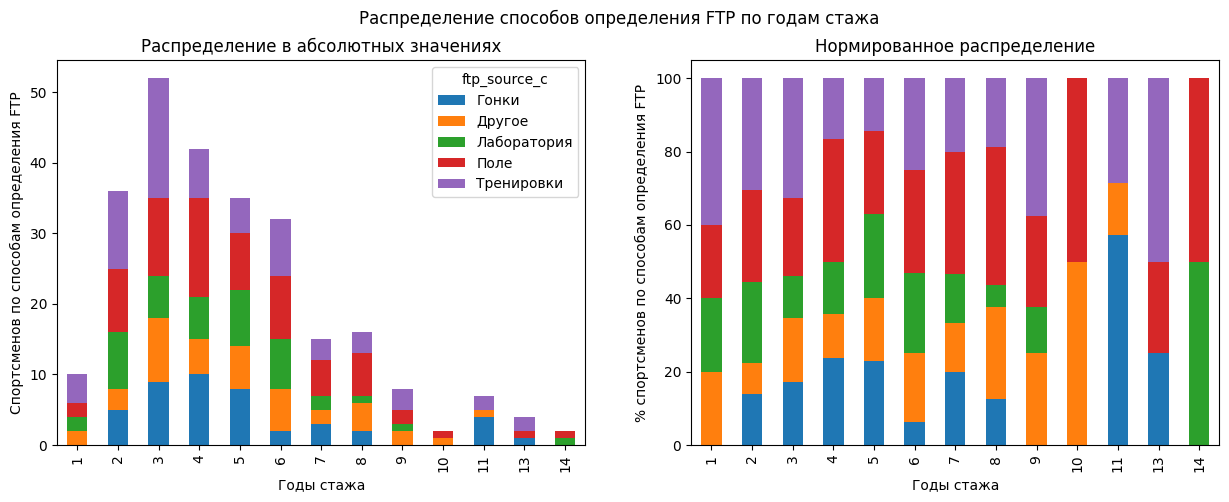

In [337]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

dd = data[['ftp_source_c', 'ftp_c', 'stag_r']].copy()
dd['stag_r'] = round(dd['stag_r'] // 12 + 1)
dd = dd.groupby(['ftp_source_c', 'stag_r'])['ftp_c'].count().reset_index()
dd = dd.pivot_table(index = 'stag_r', columns = 'ftp_source_c', values='ftp_c')
dd = dd.fillna(0)


dd.plot.bar(ax = ax[0], stacked = True, figsize=(15,5))

ax[0].set_title('Распределение в абсолютных значениях')
ax[0].set_xlabel('Годы стажа')
ax[0].set_ylabel('Спортсменов по способам определения FTP')

dd['sum'] = dd.sum(axis=1)
dd = dd.apply(lambda x: 100 * (x / x['sum']), axis=1)
dd = dd.drop(columns = 'sum')

dd.plot.bar(ax = ax[1], stacked = True, figsize=(15,5), legend = None)

ax[1].set_title('Нормированное распределение')
ax[1].set_xlabel('Годы стажа')
ax[1].set_ylabel('% спортсменов по способам определения FTP')


plt.suptitle('Распределение способов определения FTP по годам стажа')
plt.show()

# Выводы

Между FTP и длительностью велотренировок у велосипедистов и триатлетов в целом обнаруживается средняя положительная корреляция. Спортсмены, которые тренируются в неделю на один час больше, имеют и FTP в среднем на 6-7 ватт больше.

Когортный анализ тоже показывает связь роста веломинут и FTP. Взаимосвязи с тренировочным стажем также обнураживаются. Они имеют нелинейный характер и ввыходе на максимальные значения FTP на 3-6 годы, а также стабилизации веломинут. Кроме этого анализе когорт обнаружилось, что связь FTP и длительности тренировок - не монотонная. На нее как бы накладывается некая волновая функция. Природу этого эффекта выяснить не удалось. Возможно, это просто методическая ошибка.

Сравнение тренировок велосипедистов и триатлетов показало, что триатлеты имеют, можно сказать, такие же мощности как и велосипедисты. Но при этом длительность велотренировок велосипедистов на 35% большее. Скорее всего, триатлеты дорабатывают свою форму тренировкиам еще и по других видам спорта. С учетом всех тренировок, перевес в длительности уже у триатлетов, более чем в полтора раза.

Сравнение способов определения FTP не показало статистически завышение показателей каким либо из способов.